# Цели проекта

Проект направлен на комплексный анализ эффективности закупки и оптимальности загрузки транспортных средств компании занимающейся перевозкой сборных грузов.логистики сборных грузов.

Перевозка сборных грузов подразумевает консолидацию грузов от нескольких клиентов по направлению, при этом в интересах компании загрузить в одну машину как можно больше груза. Основной метрикой оценки эффективности такого подхода является показатель *утилизации* - соотношения загруженного объема груза к объему транспортного средства.

Компания использует для перевозки все виды грузовых автомобилей - от мелко тоннажных до большегрузов с повышенным объемом кузова. Отдельно необходимо оценить эффективность использования ТС (транспортных средств) повышенного объема, т.к. предполагается что они более эффективны при перевозке сборных грузов на наиболее активных направлениях.

**Ключевые метрики анализа**

*Утилизация* - основной показатель эффективности использования ТС

*Убытки от недогруза* - финансовые потери из-за недостаточной утилизации

**Основные задачи**

1. Расчет утилизации и вспомогательных полей (категории транспортных средств по объему, финансовые убытки от недогруза)

2. Построение корреляционной матрицы числовых метрик

3. Анализ общих улючевых показателей за весь период

4. Анализ утилизации и недогруза по категориям ТС

5. Определение маршрутов с самыми высокими убыткам от недогруза

6. Сравнение показателей тендерных и спотовых рейсов

# Описаание данных

В ходе работы будут использоваться данные о рейсах транспортной компании за период с января по сентябрь 2023г.

* *СО* - склад отправитель, первая точка маршрута

* *СП* - склад получатель, последняя точка маршрута

* *ПО* - плечо отправитель

* *ПП* - плечо получатель

* *Код рейса* - идентификатор рейса

* *Маршрут* - маршрут рейса. Может содержать более двух точек

* *Плечо* - текущее плечо рейса

* *Отправление* - дата и время отправки рейса

* *Прибытие* - дата и время фактического прибытия рейса в точку назначения

* *Прибытие план* - рассчетная дата и время прибытия рейса в следующую точку маршрута. Формируется автоматически после отправки.

* *Окончание разгрузки* - дата и время разгрузки рейса

* *Объем кузова* - объем транспортного средства в рейсе, в метрах кубических

* *Объем в пути* - объем груза в транспортном средстве после отправки, в метрах кубических

* *Вес в пути* - вес груза в транспортном средстве после отправки, в кг

* *Расстояние фрахта* - полное расстояние между всеми точками маршрута рейса, в км

* *Расстояние плеча* - расстояние текущего плеча рейса, в км

* *Перевозчик* - компания перевозчик

* *Фрахт фактический* - стоимость закупки транспортных услуг у компании перевозчика за рейс, условная валюта

* *Тендер* - номер тендера в который входит рейс. Для не тендерных рейсов - `'0'`.

# 1. Загрузка данных и знакомство

In [74]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
path = '/content/routes_data_1.xlsx'

# Импорт данных
df = pd.read_excel('/content/routes_data_1.xlsx')

In [76]:
# Вывод информации о полях
df.info()

# вывод первых строк датасета
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140095 entries, 0 to 140094
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   со                   140095 non-null  object        
 1   сп                   140095 non-null  object        
 2   по                   140095 non-null  object        
 3   пп                   140095 non-null  object        
 4   код_рейса            140095 non-null  object        
 5   маршрут              140095 non-null  object        
 6   плечо                140095 non-null  object        
 7   отправление          140095 non-null  datetime64[ns]
 8   прибытие             140095 non-null  datetime64[ns]
 9   прибытие_план        140095 non-null  datetime64[ns]
 10  окончание_разгрузки  140095 non-null  datetime64[ns]
 11  объем_кузова         140095 non-null  float64       
 12  объем_в_пути         140095 non-null  float64       
 13  вес_в_пути    

,со,сп,по,пп,код_рейса,маршрут,плечо,отправление,прибытие,прибытие_план,окончание_разгрузки,объем_кузова,объем_в_пути,вес_в_пути,расстояние_фрахта,расстояние_плеча,перевозчик,фрахт_фактический,менеджер,тендер
0,ОТ,ИЖ,ОТ,ИЖ,0301ОТИЖ-1,ОТИЖ,ОТИЖ,2023-01-03 00:38:07,2023-01-03 08:49:45,2023-01-03 09:00:00,2023-01-03 11:47:36,82.10,74.61,15929.50,359.8,359.8,Мега Групп,350,Менеджер 12,0
1,КР,МБ,КР,МБ,3012КРМБ-1,КРМБ,КРМБ,2023-01-03 10:55:55,2023-01-05 05:43:18,2023-01-05 05:55:55,2023-01-05 18:00:34,85.71,70.44,14970.78,1327.8,1327.8,Квант Маркет Инк,1120,Менеджер 15,0
2,АМ,НМ,МБ,АМ,3012МБАМНМ,МБАМНМ,АМНМ,2023-01-03 12:03:51,2023-01-03 13:35:34,2023-01-03 14:03:51,2023-01-03 12:00:15,85.71,72.66,11901.00,1442.8,85.4,Квант Ресурс Групп,2270,Менеджер 13,0
3,ПК,НК,ПК,НК,0301ПКНК,ПКНК,ПКНК,2023-01-03 13:30:42,2023-01-03 15:00:04,2023-01-03 14:30:42,2023-01-03 14:58:17,40.87,0.87,82.14,42.8,42.8,Профи Маркет Холдинг,80,Менеджер 1,0
4,МЮ,МБ,МЮ,МБ,0301МЮМБ,МЮМБ,МЮМБ,2023-01-03 13:34:11,2023-01-03 14:15:48,2023-01-03 14:34:11,2023-01-04 02:44:41,85.71,39.55,7115.98,7.6,7.6,Мега Групп,110,Менеджер 5,0


На первый взгляд данные соотвествуют описанию полей и типам данных. Пропусков в полях нет.

Проверим распределение значений числовых полей.

In [77]:
def check_numeric(df):
    """
    Анализирует числовые колонки датафрейма: выводит статистику и визуализацию
    """
    for column in df.columns:
        # Проверяем является ли поле числовым
        if pd.api.types.is_numeric_dtype(df[column]):
            print(f"ОПИСАНИЕ ДАННЫХ ЧИСЛОВОГО ПОЛЯ {column}")
            display(df[column].describe())
            print(f"\nРаспределение значений поля {column}")

            # Визуализация
            plt.figure(figsize=(10, 4))

            # Гистограмма
            plt.subplot(1, 2, 1)
            sns.histplot(
                data=df,
                x=column,
                bins=15
            )
            plt.title(f"Распределение значений {column}")
            plt.xlabel('Значение')
            plt.ylabel('Кол-во')

            # Boxplot
            plt.subplot(1, 2, 2)
            sns.boxplot(
                data=df,
                x=column
            )
            plt.title(f"Диаграмма размаха поля {column}")
            plt.tight_layout()
            plt.show()

            print()
            print()

ОПИСАНИЕ ДАННЫХ ЧИСЛОВОГО ПОЛЯ объем_кузова


,объем_кузова
count,140095.000000
mean,74.496498
std,21.779773
min,13.180000
25%,67.510000
50%,84.340000
75%,85.710000
max,137.590000



Распределение значений поля объем_кузова


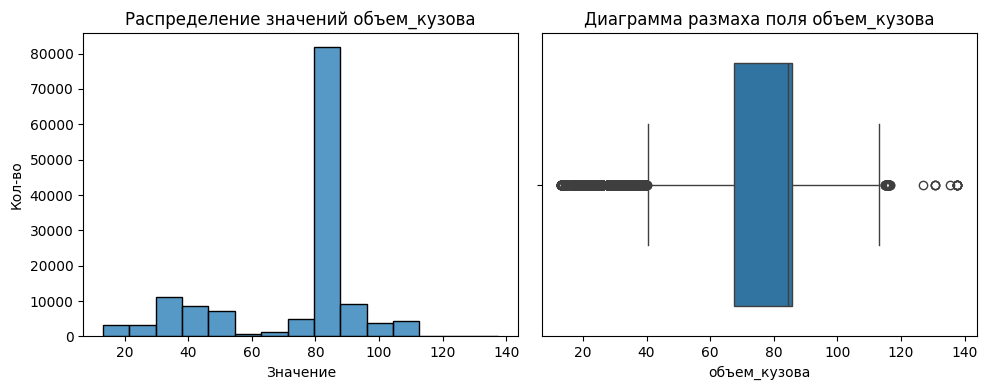



ОПИСАНИЕ ДАННЫХ ЧИСЛОВОГО ПОЛЯ объем_в_пути


,объем_в_пути
count,140095.000000
mean,44.000988
std,25.489618
min,0.010000
25%,20.250000
50%,46.160000
75%,67.000000
max,109.140000



Распределение значений поля объем_в_пути


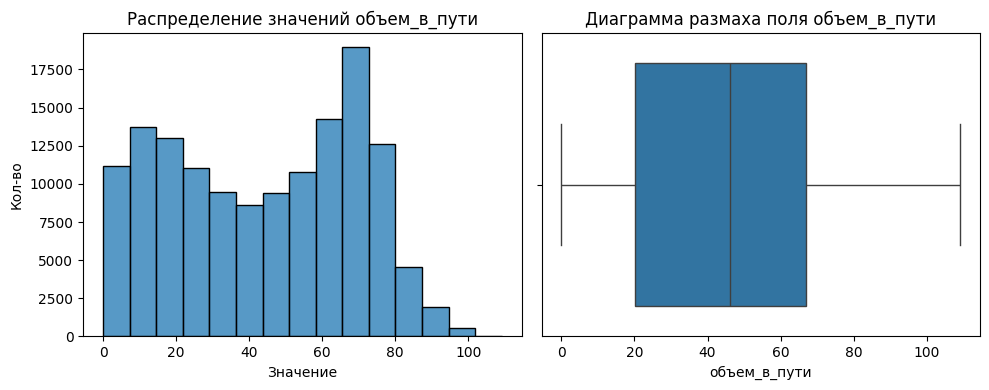



ОПИСАНИЕ ДАННЫХ ЧИСЛОВОГО ПОЛЯ вес_в_пути


,вес_в_пути
count,140095.000000
mean,8592.734958
std,5050.300510
min,0.010000
25%,4051.630000
50%,8822.880000
75%,12571.070000
max,22466.550000



Распределение значений поля вес_в_пути


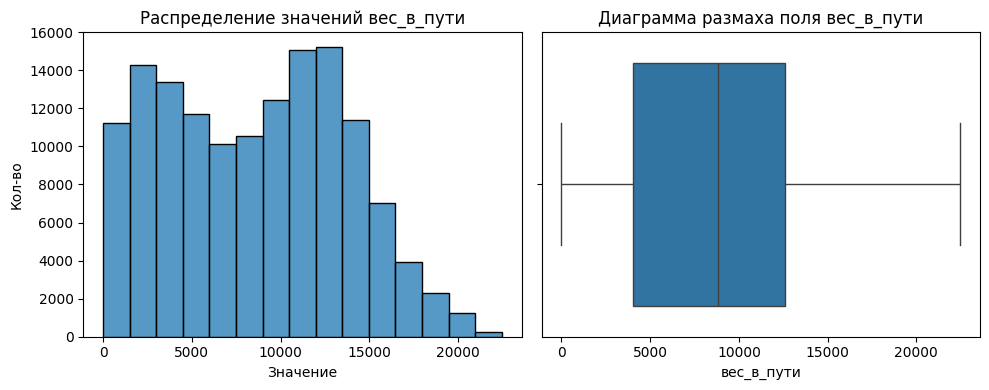



ОПИСАНИЕ ДАННЫХ ЧИСЛОВОГО ПОЛЯ расстояние_фрахта


,расстояние_фрахта
count,140095.000000
mean,772.420344
std,1255.052669
min,0.600000
25%,56.900000
50%,353.900000
75%,919.500000
max,10100.534000



Распределение значений поля расстояние_фрахта


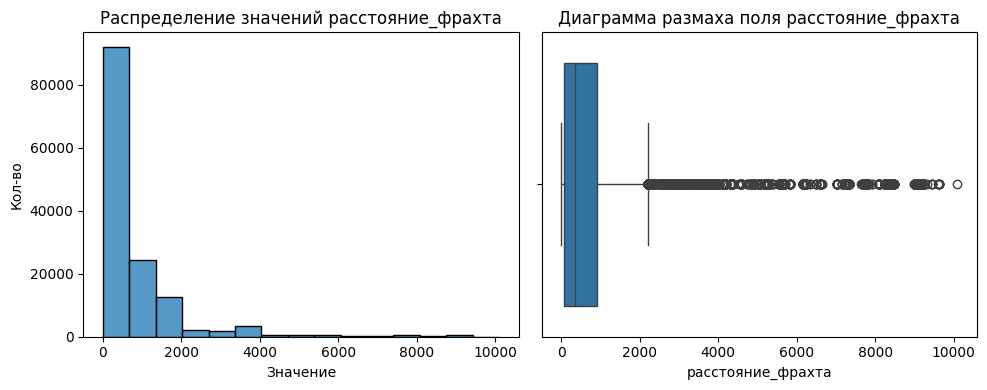



ОПИСАНИЕ ДАННЫХ ЧИСЛОВОГО ПОЛЯ расстояние_плеча


,расстояние_плеча
count,140095.000000
mean,626.110677
std,1106.903501
min,0.600000
25%,45.900000
50%,241.200000
75%,725.200000
max,10100.534000



Распределение значений поля расстояние_плеча


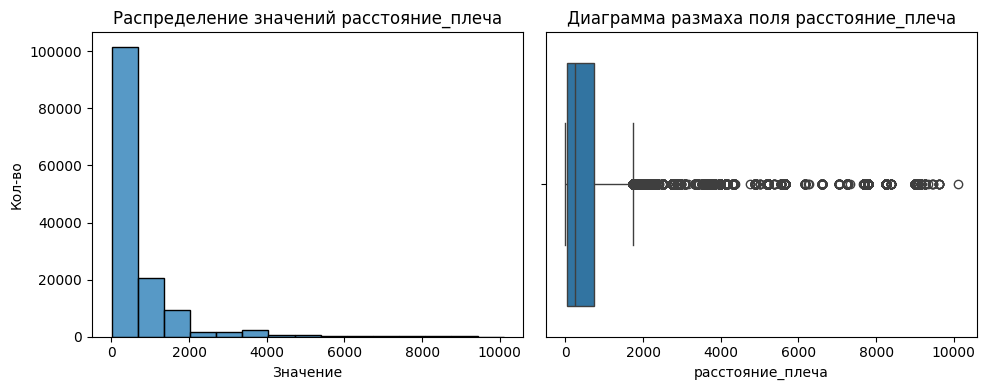



ОПИСАНИЕ ДАННЫХ ЧИСЛОВОГО ПОЛЯ фрахт_фактический


,фрахт_фактический
count,140095.000000
mean,739.364574
std,1136.678179
min,20.000000
25%,130.000000
50%,290.000000
75%,840.000000
max,11200.000000



Распределение значений поля фрахт_фактический


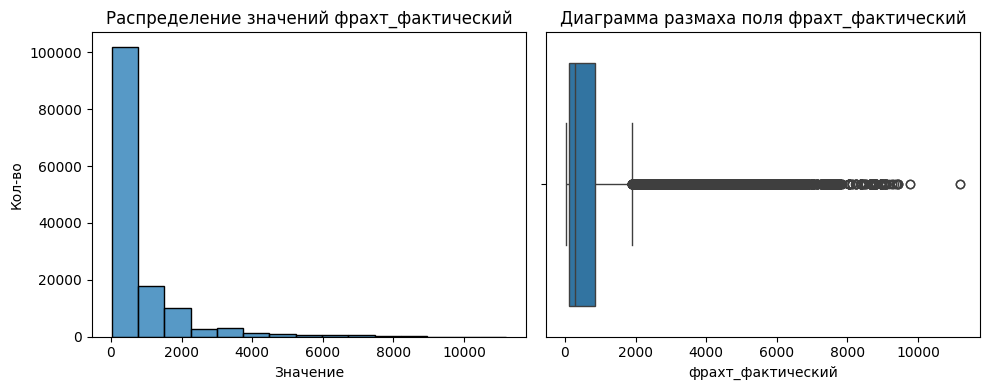

In [78]:
check_numeric(df)

Аномалий не обнаружено. Теперь оценим временные границы данных.

In [79]:
display(df['отправление'].describe(),df['прибытие'].describe())

,отправление
count,140095
mean,2023-05-10 11:15:31.180284672
min,2023-01-03 00:38:07
25%,2023-03-12 05:46:15
50%,2023-05-12 04:03:55
75%,2023-07-10 03:27:47
max,2023-09-07 22:06:51


,прибытие
count,140095
mean,2023-05-11 05:45:55.238302208
min,2023-01-03 08:49:45
25%,2023-03-13 10:04:09.500000
50%,2023-05-12 18:38:52
75%,2023-07-10 20:24:43
max,2023-09-08 01:36:29


Ошибок нет. Максимальная дата отправления 7 сентября 2023, следовательно данные за сентябрь неполные. Отфильтруем их.

Дополнительно введем новое поле с месяцем отправки рейса которое понадобится для дальнейших рассчетов.

In [80]:
# фильтруем данные до сентября 2023
df = df[df['отправление']<'2023-09-01']

# введем новое поле месяц отправления рейса
df['месяц_отправки'] = df['отправление'].dt.to_period('M').dt.to_timestamp()

# 2. Рассчет утилизации и вспомогательных полей

Для рассчета утилизации нужно разделить объем рейса в пути на объем транспортного средства.

Датасет хранит данные о всех рейсх компании в период с января по сентябрь 2023г, в том числе данные о рейсах с тремя и более точками маршрута.


In [81]:
df[['код_рейса','маршрут','объем_кузова','объем_в_пути']].sort_values('код_рейса').tail(2)

# копируем датасет
dfu = df.copy(deep=True)
# сортируем по убыванию значений объема в пути и удаляем строки с меньшим значением
dfu = dfu.sort_values(['код_рейса','объем_в_пути'], ascending=False)
dfu = dfu.drop_duplicates(subset='код_рейса',keep='first')

print( f"Удалено строк : {(df.shape[0]-dfu.shape[0])}")

# проверяем на дубликаты
print( f"\nЧисло явных дубикатов : {dfu.duplicated().sum()}")

print( f"\nЧисло дубикатов по полю код рейса: {dfu.duplicated(subset='код_рейса').sum()}")

print( f"\nЧисло дубикатов по полям 'код_рейса','отправление' : {dfu.duplicated(subset=['код_рейса','отправление']).sum()}")

print('\n')

Удалено строк : 12270

Число явных дубикатов : 0

Число дубикатов по полю код рейса: 0

Число дубикатов по полям 'код_рейса','отправление' : 0




Теперь введем новые поля необходимые для оценки утилизации :

* *утилизация* - отношение объема в пути к объему ТС. Для удобства переведем показатель в %.

* *категория_тс* - разделим транспортные средства на категории для более дальнейшей оценки.

* *убыток* - убыток от неполной загрузки транспортного средства. Т.к. нормативом компании заложен порог утилизации в 85% все что ниже этого показателя будем счиать убытком. Для рейсов с утилизацией 85% и выше убыток не считаем.

Т.к. компания выполняет доставку грузов всеми видами транспорта от малотоннажного (газели и небольшие грузовики) до грузовых автомобилей с увеличенным объемом полуприцепа введем следующие категории :

* До 30 м3 (все мелкотоннажные ТС)

* От 30 до 70 м3 (среднетоннажные ТС)

* От 70 до 90 м3 (евро-фуры с тентованным полу-прицепом или рефрижератором)

* 90 и более (евро-фуры с прицепом повышенного объема)

Особенно важно исследовать эффективность последней категории т.к. расходы на закупку тааких ТС выше, чем на стандартные фуры.

Построим гистограмму распределения всех рейсов исходя из объема транспортного средства.

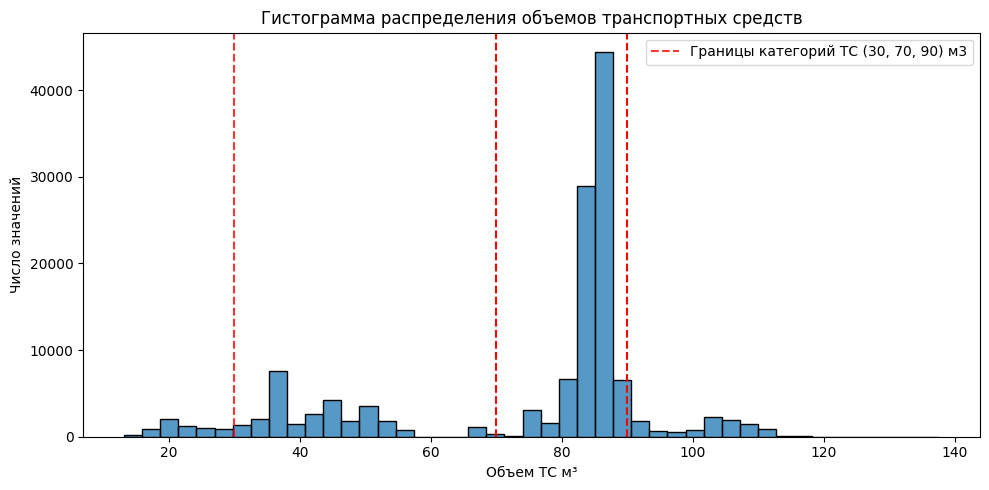

In [82]:
plt.figure(figsize=(10,5))
# гистограмма
sns.histplot(
    data=df,
    x=df['объем_кузова'],
    bins=45
)
# Оформление
plt.title('Гистограмма распределения объемов транспортных средств')
plt.xlabel('Объем ТС м³')
plt.ylabel('Число значений')
plt.axvline(x=30,linestyle='--',color='r',alpha=0.8,label='Границы категорий ТС (30, 70, 90) м3')
plt.axvline(x=70,linestyle='--',color='r')
plt.axvline(x=90,linestyle='--',color='r')
plt.legend()

plt.tight_layout()
plt.show()

По графику видно, что большая часть перевозок компании осуществляется ефврофурами объемом 70-90 м3. В целом распределение равномерно укладывается в заданные границы.

Приступим к рассчету полей :

  * Для ТС где загружено больше 19.5 тонн присвоим утилизацию равную 100 % т.к. максимальная допустимая загрузка по весу составляет 20 тонн. Для остальных рейсов рассчитаем как соотношение объема в пути к объему ТС

  * Для рассчета убытков используем показатель нормативной утилизации компании - 85%. Все, что загружено ниже этой границы будем считать убытком от недогруза.

In [83]:
# Определение утилизации
def define_utilization(row, threshold=19500):
    if row['вес_в_пути'] >= threshold:
        return 100.0
    else:
        if row['объем_кузова'] == 0:
            return 0.0
        utilization = (row['объем_в_пути'] / row['объем_кузова']) * 100
        return round(utilization, 2)

In [84]:
# Определение категории ТС
def t_volume_cat (row):
    if row['объем_кузова'] <= 30:
        return 'до 30'
    elif row['объем_кузова'] > 30 and row['объем_кузова'] < 70:
        return '30-70'
    elif row['объем_кузова'] >= 70 and row['объем_кузова'] <= 90:
        return '70-90'
    else:
        return '90+'

In [85]:
# Определение недогруза в деньгах
def define_m_loss(row, threshold=85):
    # Если утилизация рейса больше или равна нормативной не считаем убыток
    if row['утилизация'] >= threshold:
        return 0
    # Если утилизация меньше нормативной считаем убыток как разницу от норматива умноженную на стоимость рейса
    else:
        return (threshold - (row['утилизация']))/100 * row['фрахт_фактический']

In [86]:
# Рассчет полей
dfu['утилизация'] = dfu.apply(define_utilization, axis=1)
dfu['категория_тс'] = dfu.apply(t_volume_cat, axis=1)
dfu['убыток'] = dfu.apply(define_m_loss, axis=1)
dfu.head(5)

,со,сп,по,пп,код_рейса,маршрут,плечо,отправление,прибытие,прибытие_план,...,расстояние_фрахта,расстояние_плеча,перевозчик,фрахт_фактический,менеджер,тендер,месяц_отправки,утилизация,категория_тс,убыток
136575,ЯР,МС,ЯР,МС,3108ЯРФР01ЯРМС,ЯРФР01ЯРМС,ЯРМС,2023-08-31 21:43:18,2023-09-01 02:34:35,2023-09-01 02:43:18,...,280.2,266.7,Мега Групп,370,Менеджер 10,0,2023-08-01,90.94,70-90,0.000
136578,ЯР,МБ,ЯР,МБ,3108ЯРМБ-2,ЯРМБ,ЯРМБ,2023-08-31 21:50:43,2023-09-01 04:12:27,2023-09-01 03:50:43,...,306.6,306.6,Глобал Шипмент Групп,180,Менеджер 26,0,2023-08-01,79.03,30-70,10.746
136496,ЯР,МБ,ЯР,МБ,3108ЯРМБ-1,ЯРМБ,ЯРМБ,2023-08-31 19:25:52,2023-09-01 01:35:23,2023-09-01 02:25:52,...,306.6,306.6,Мега Групп,310,Менеджер 10,Id3431,2023-08-01,74.69,70-90,31.961
136348,ЯЛ,СФ,ЯЛ,СФ,3108ЯЛСФ,ЯЛСФ,ЯЛСФ,2023-08-31 16:31:45,2023-08-31 18:41:00,2023-08-31 20:00:00,...,86.7,86.7,Мега Групп,80,Менеджер 2,0,2023-08-01,37.69,до 30,37.848
136428,ЭЛ,МБ,ЭЛ,МБ,3108ЭЛМБ-1,ЭЛМБ,ЭЛМБ,2023-08-31 18:07:35,2023-08-31 21:43:38,2023-08-31 20:07:35,...,86.1,86.1,Мега Пром,250,Менеджер 9,Id3250,2023-08-01,73.10,70-90,29.750


ОПИСАНИЕ ДАННЫХ ЧИСЛОВОГО ПОЛЯ утилизация


,утилизация
count,124361.000000
mean,57.861568
std,26.326997
min,0.020000
25%,37.150000
50%,62.580000
75%,80.350000
max,100.000000



Распределение значений поля утилизация


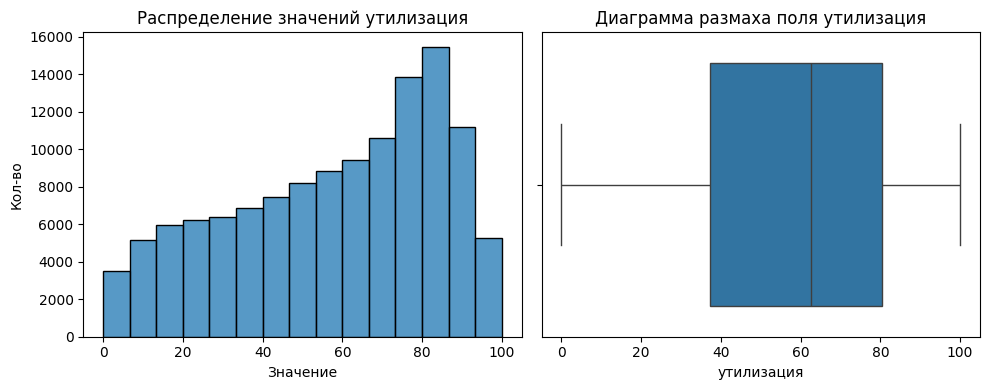



ОПИСАНИЕ ДАННЫХ ЧИСЛОВОГО ПОЛЯ убыток


,убыток
count,124361.000000
mean,72.033619
std,98.309292
min,0.000000
25%,16.212000
50%,48.050000
75%,92.961000
max,5572.230000



Распределение значений поля убыток


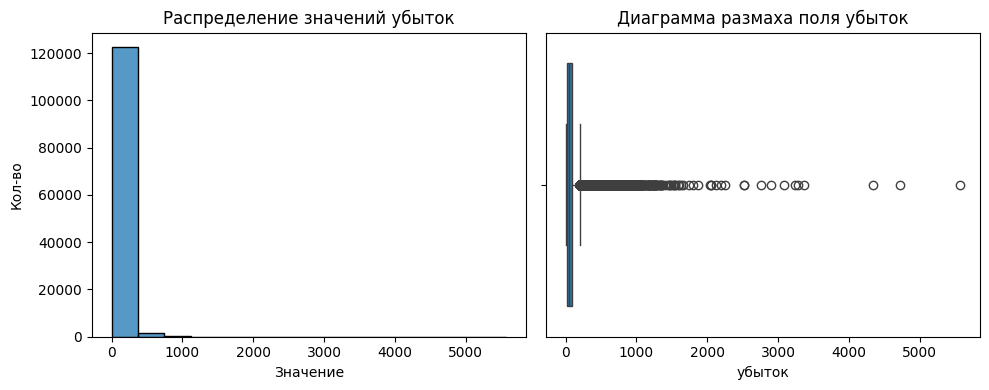

In [87]:
# Проверка данных новых полей
check_numeric(dfu[['утилизация','убыток']])

Значения поля утилизация распределны почти нормально, медианное значение близко к среднему. При этом можно отметить большое кол-во значений близких к 0, что указывает на большое число рейсов отправленных практически пустыми.

Большая часть значений поля убыток не достигает значения 100, при этом на диаграмме размаха видно большое кол-во рейсов с высокими разовыми убытками, максимум превышает 5000. Это указывает на налоичие дорогих рейсов с низкой утилизацией.



# 3. Построение матрицы корреляций числовых полей

Теперь определим есть ли корреляции у следующих числовых полей датасета :

* утилизация

* убыток

* фрахт фактический

* расстояние плеча

* объем кузова

* вес в пути

Рассчитаем корреляцию методом Спирмена т.к. он менее чувствителен к выбросам которые есть в данных.

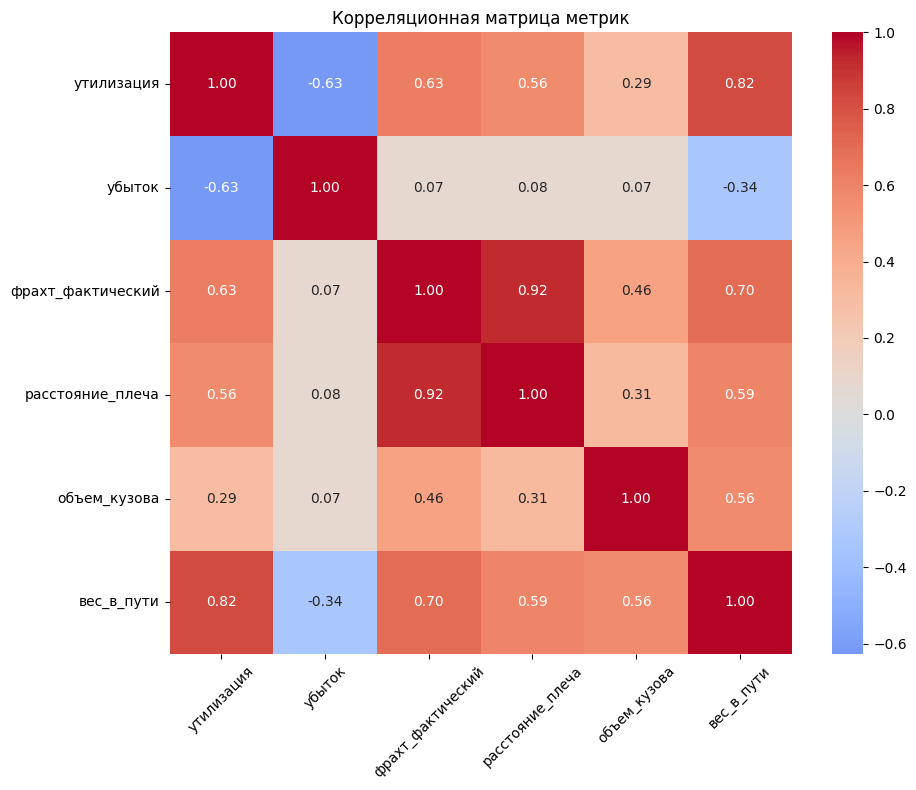

In [88]:
# Матрица корреляций
# Поля для проверки
numeric_cols = ['утилизация', 'убыток', 'фрахт_фактический',
                'расстояние_плеча', 'объем_кузова','вес_в_пути']
# Расчет корреляции по Спирмену
correlation_matrix = dfu[numeric_cols].corr(method='spearman')
# Тепловая карта
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f',
            xticklabels=numeric_cols,
            yticklabels=numeric_cols)

# Оформление
plt.xticks(rotation=45, ha='center')
plt.yticks(rotation=0)

plt.xlabel('')
plt.title('Корреляционная матрица метрик')
plt.tight_layout()
plt.show()

Тепловая карта корреляций подтверждает очевидные связи между данными :

* Утилизация - Убыток (-0.62) - значительная связь, чем выше утилизация тем меньше убыток.

* Расстояние - стоимость фрахта (0.92) - чем больше расстояние рейса, тем выше стоимость.

Можно отметить следующие моменты :

* Утилизация - Стоимость фрахта (0.63) - умеренно сильная связь. Она ниже, чем можно было бы ожидать, если бы дорогие рейсы действительно загружались лучше. Это может указывать на то, что загрузка дорогих рейсов не всегда оптимальна.

* Утилизация - Расстояние (0.56) - умеренная связь, но она ниже ожидаемой. Это может указывать на то, что длинные рейсы не всегда загружены оптимально, однако для подтверждения нужны дополнительные разрезы и сравнение утилизации по группам расстояния.

* Утилизация - Объем кузова (0.29) - очень слабая связь. Предолагалось, что больее объемные ТС должны иметь более высокий показатель утилизации для уменьшения убытков, но полученный к-т не подтверждает эту связь.

**Выводы**

Общий вывод:
Корреляционный анализ показывает, **что ключевым фактором, влияющим на убытки, остаётся утилизация**: чем выше загрузка, тем ниже убытки.

Логично сильная связь наблюдается между расстоянием и стоимостью фрахта, что отражает корректность базовой структуры тарифов компании.

В то же время связи между **утилизацией** и такими параметрами, как *стоимость рейса*, *расстояние* и *объём кузова*, оказались значительно слабее ожидаемых, что говорит о том, что загрузка транспорта не полностью определяется экономикой рейса или характеристиками ТС. Вероятно, существует потенциал для улучшения процессов планирования.

# 4. Анализ общей утилизации, числа рейсов и убытков от недогруза

In [89]:
# Группировка данных по месяцам
ut_monthly = dfu.groupby('месяц_отправки').agg({
    'утилизация':'mean',
    'код_рейса':'nunique',
    'убыток':'sum',
    'фрахт_фактический':'sum'
}).reset_index()

ut_monthly

,месяц_отправки,утилизация,код_рейса,убыток,фрахт_фактический
0,2023-01-01,55.546387,12275,833573.132,7055720
1,2023-02-01,57.462805,13667,927796.043,8615280
2,2023-03-01,58.953464,16254,1071467.571,10549700
3,2023-04-01,58.999157,16128,1137759.763,11132570
4,2023-05-01,57.062257,16157,1229688.188,10855120
5,2023-06-01,57.766527,16448,1238572.466,11575130
6,2023-07-01,58.153673,16527,1211520.664,12035290
7,2023-08-01,58.300738,16905,1307795.039,12511780


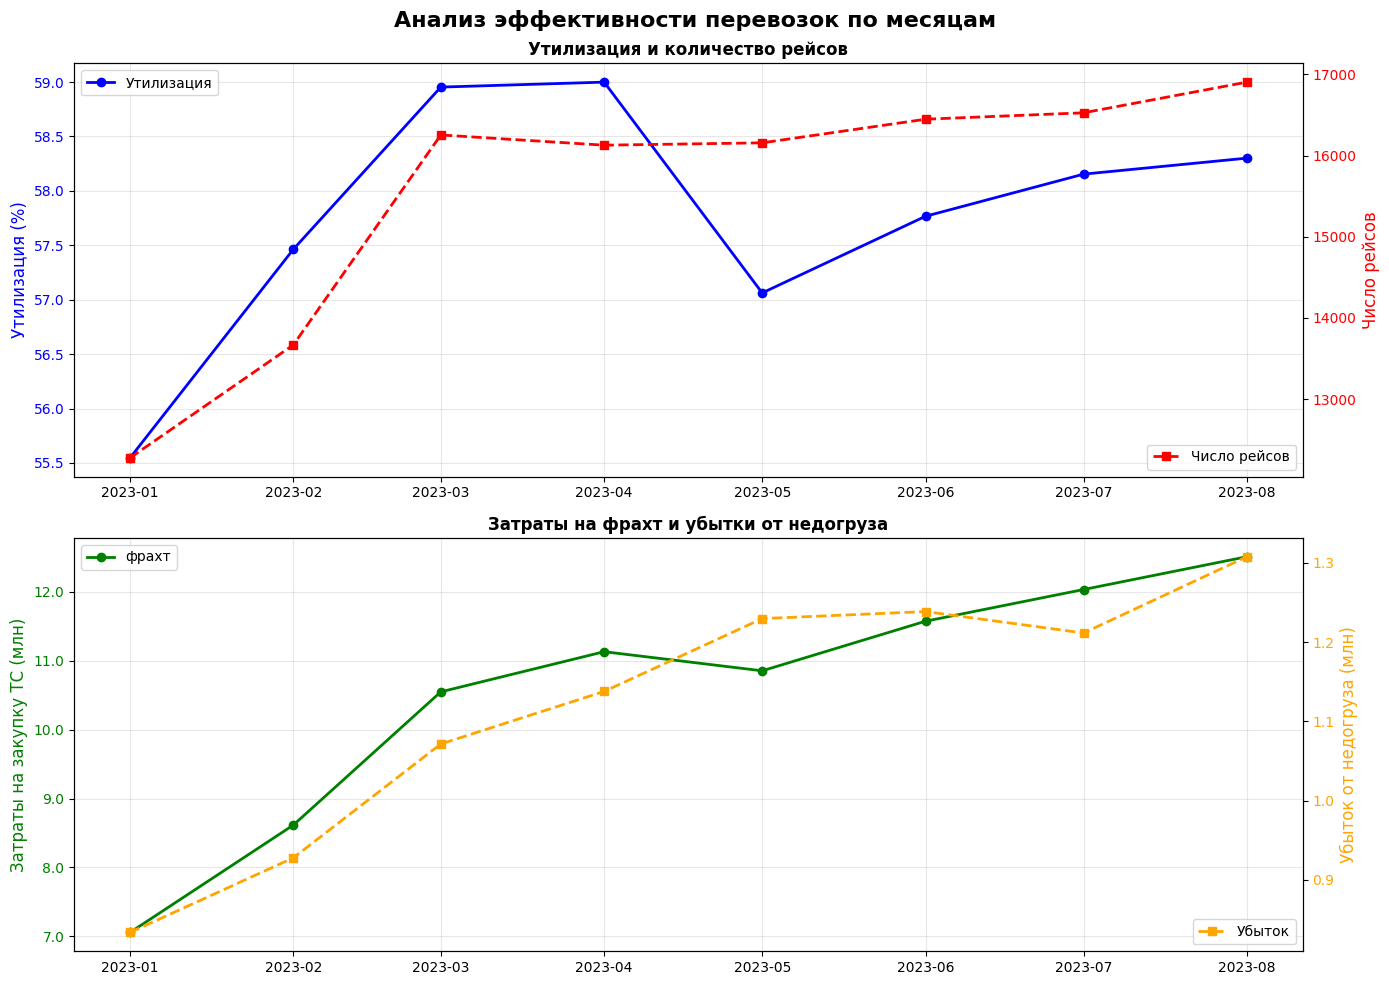

In [90]:
# Создание сетки
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# График 1: Утилизация и рейсы
ax1.plot(ut_monthly['месяц_отправки'], ut_monthly['утилизация'],
         color='blue', marker='o', linewidth=2, label='Утилизация')
ax1.set_ylabel('Утилизация (%)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)
ax1.set_title('Утилизация и количество рейсов', fontweight='bold')

ax1_r = ax1.twinx()
ax1_r.plot(ut_monthly['месяц_отправки'], ut_monthly['код_рейса'],
           color='red', marker='s', linestyle='--', linewidth=2, label='Число рейсов')
ax1_r.set_ylabel('Число рейсов', color='red', fontsize=12)
ax1_r.tick_params(axis='y', labelcolor='red')

# График 2: Фрахт и убытки
ax2.plot(ut_monthly['месяц_отправки'], ut_monthly['фрахт_фактический'],
         color='green', marker='o', linewidth=2, label='фрахт')
ax2.set_ylabel('Затраты на закупку ТС (млн)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')
ax2.grid(True, alpha=0.3)
ax2.set_title('Затраты на фрахт и убытки от недогруза', fontweight='bold')

ax2_r = ax2.twinx()
ax2_r.plot(ut_monthly['месяц_отправки'], ut_monthly['убыток'],
           color='orange', marker='s', linestyle='--', linewidth=2, label='Убыток')
ax2_r.set_ylabel('Убыток от недогруза (млн)', color='orange', fontsize=12)
ax2_r.tick_params(axis='y', labelcolor='orange')

# Форматирование осей
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))
ax2_r.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))

# Общие легенды
ax1.legend(loc='upper left')
ax1_r.legend(loc='lower right')
ax2.legend(loc='upper left')
ax2_r.legend(loc='lower right')

plt.suptitle('Анализ эффективности перевозок по месяцам', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

* В целом средний показатель утилизации по всем рейсам стабилен - минимальное значение 55.5% в январе, максимальный 59% в апреле. При этом, показатель очень далек от целевого в 85%. Можно отметить что утилизация растет с января по апрель вместе с числом рейсов, но в апреле падает на 2 п.п. и начинает медленный рост.

* Число рейсов стабильно растет с января что хорошо показывет сезонность рынка - низкий спрос в начале года, его рост и стабилизация весной и постепенный рост к концу года.

* Затраты на закупку транспортных средств (фрахт) так же растут с января. В апреле наблюдается небольшое падение, но затем рост возобновляется.

* Убытки от недогруза так же растут. Можно отметить небольшое снижение в июне, но уже в конце июля.


**Вывод**

Несмотря на сезонный рост числа рейсов, средняя утилизация остаётся стабильно низкой (55–59%) и далека от целевого уровня в 85%.

Вместе с ростом числа рейсов растут и затраты на закупку транспорта, а **стабильно низкая утилизация является ключевым драйвером роста убытков от недогруза.**

# 5. Анализ утилизации и недогруза по категориям ТС

Рассмотрим в разрезе категорий ТС следующие показатели :

* Число рейсов

* Среднюю утилизацию

* Общий убыток

* средний убыток рейса

In [91]:
# Группировка по категориям

cat_groupped = dfu.groupby('категория_тс').agg({
    'код_рейса':'nunique',
    'фрахт_фактический':'sum',
    'утилизация':'mean',
    'убыток':'sum'
}).reset_index()
cat_groupped['средний_убыток'] = cat_groupped['убыток'] / cat_groupped['код_рейса']
cat_groupped['средняя_стоимость'] = cat_groupped['фрахт_фактический'] / cat_groupped['код_рейса']
cat_groupped['соотношение'] = (cat_groupped['убыток'] / cat_groupped['фрахт_фактический'])*100

cat_groupped

,категория_тс,код_рейса,фрахт_фактический,утилизация,убыток,средний_убыток,средняя_стоимость,соотношение
0,30-70,26925,4662870,40.146335,1624610.349,60.338360,173.179944,34.841425
1,70-90,81021,62409400,63.186721,6042736.870,74.582354,770.286716,9.682415
2,90+,10245,16662610,71.901970,1049321.465,102.422788,1626.413860,6.297462
3,до 30,6170,595710,41.927942,241504.182,39.141683,96.549433,40.540562


In [92]:
cat_groupped['соотношение'] = cat_groupped['убыток'] / cat_groupped['фрахт_фактический']

cat_groupped

,категория_тс,код_рейса,фрахт_фактический,утилизация,убыток,средний_убыток,средняя_стоимость,соотношение
0,30-70,26925,4662870,40.146335,1624610.349,60.338360,173.179944,0.348414
1,70-90,81021,62409400,63.186721,6042736.870,74.582354,770.286716,0.096824
2,90+,10245,16662610,71.901970,1049321.465,102.422788,1626.413860,0.062975
3,до 30,6170,595710,41.927942,241504.182,39.141683,96.549433,0.405406


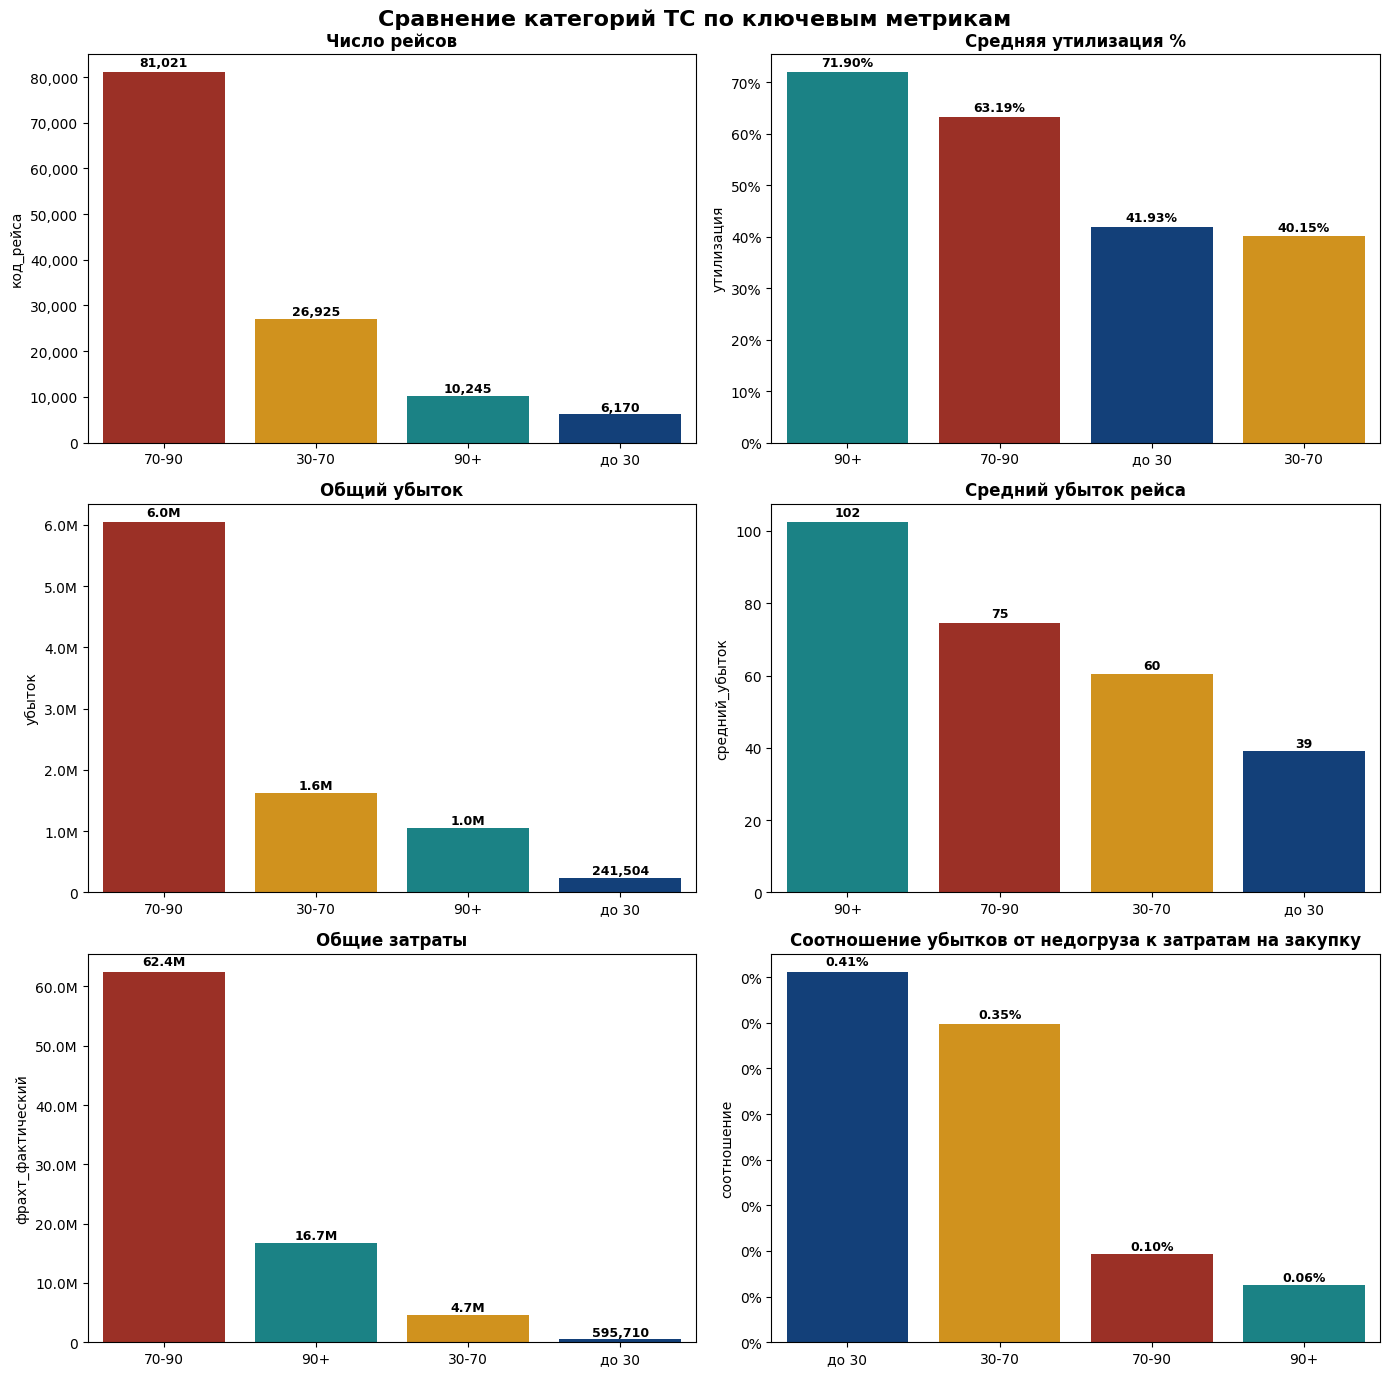

In [93]:
# Создание сетки 3 на 2 для подграфиков
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
# Цвета
colors = {'до 30':'#023e8a','30-70':'#ee9b00','70-90':'#ae2012','90+':'#0a9396'}
# Параметры : Метрика: (название подграфика, формат оси)
config = {
    'код_рейса': ('Число рейсов', 'count'),
    'утилизация': ('Средняя утилизация %', 'pct'),
    'убыток': ('Общий убыток', 'money'),
    'средний_убыток': ('Средний убыток рейса', 'money'),
    'фрахт_фактический': ('Общие затраты', 'money'),
    'соотношение': ('Соотношение убытков от недогруза к затратам на закупку', 'pct')
}
# Данные для графика
plot_data = cat_groupped.reset_index()
# Построение графиков
for k, (metric, (title, fmt)) in enumerate(config.items()):
    ax = axes[k//2, k%2]

    # Барплот
    sns.barplot(data=plot_data.sort_values(metric,ascending=False), x='категория_тс', y=metric,
                hue='категория_тс', palette=colors, legend=False, ax=ax)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')

    # Подписи значений на барах
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            text = f'{height:.2f}%' if fmt == 'pct' else f'{height/1e6:.1f}M' if fmt == 'money' and height >= 1e6 else f'{height:,.0f}'
            ax.text(bar.get_x() + bar.get_width()/2, height*1.01, text,
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Форматирование оси У
    if fmt == 'pct':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    elif fmt == 'money':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y/1e6:.1f}M' if y >= 1e6 else f'{y/1e3:.0f}K' if y >= 1e3 else f'{y:,.0f}'))
    else:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}'))
# Оформление
plt.suptitle('Сравнение категорий ТС по ключевым метрикам', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

* Низкая утилизация категорий 30-70 и до 30 сильно влияют на общий показатель утилизации по всем рейсам.

* Большая часть рейсов выполняется фурами объемом 70-90 м3, на них же приходится большая часть убытков от недогруза. Основная причина - невысокая средняя утилизация рейсов 63%.

* На втором месте среднетоннажный транспорт объемом 30-70 м3. Несмотря на то что общие убытки от недогруза по этой категории почти в 5 раз меньше чем по 70-90, они все еще значительны.

* Категория 90+ показывает лучший показатель по средней утилизации 72%. Самый высокий средний убыток с рейса объясняется высокой средней стоимостью рейса. При этом, категорию можно считать самой эффективной т.к. она имеет минимальное соотношение убытков к затратам.

* Для категории до 30 м3 характерно самое высокое соотношение убытков от недогруза к затратам на закупку. При этом, из-за минимального числа рейсов и низкой средней стоимости рейса общие убытки по категории так же минимальны.



Теперь рассмотрим показатели по категориям по месяцам.

In [94]:
dfu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124361 entries, 136575 to 14092
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   со                   124361 non-null  object        
 1   сп                   124361 non-null  object        
 2   по                   124361 non-null  object        
 3   пп                   124361 non-null  object        
 4   код_рейса            124361 non-null  object        
 5   маршрут              124361 non-null  object        
 6   плечо                124361 non-null  object        
 7   отправление          124361 non-null  datetime64[ns]
 8   прибытие             124361 non-null  datetime64[ns]
 9   прибытие_план        124361 non-null  datetime64[ns]
 10  окончание_разгрузки  124361 non-null  datetime64[ns]
 11  объем_кузова         124361 non-null  float64       
 12  объем_в_пути         124361 non-null  float64       
 13  вес_в_пути     

In [95]:
group_cols = ['месяц_отправки','категория_тс']

route_ut_monthly = dfu.groupby(group_cols).agg(
    total_losses = ('убыток','sum'),
    avg_ut = ('утилизация','mean'),
    trips = ('код_рейса','nunique'),
    total_cost = ('фрахт_фактический','sum')
).reset_index()
route_ut_monthly['losses_to_cost'] = (route_ut_monthly['total_losses'] / route_ut_monthly['total_cost'])*100


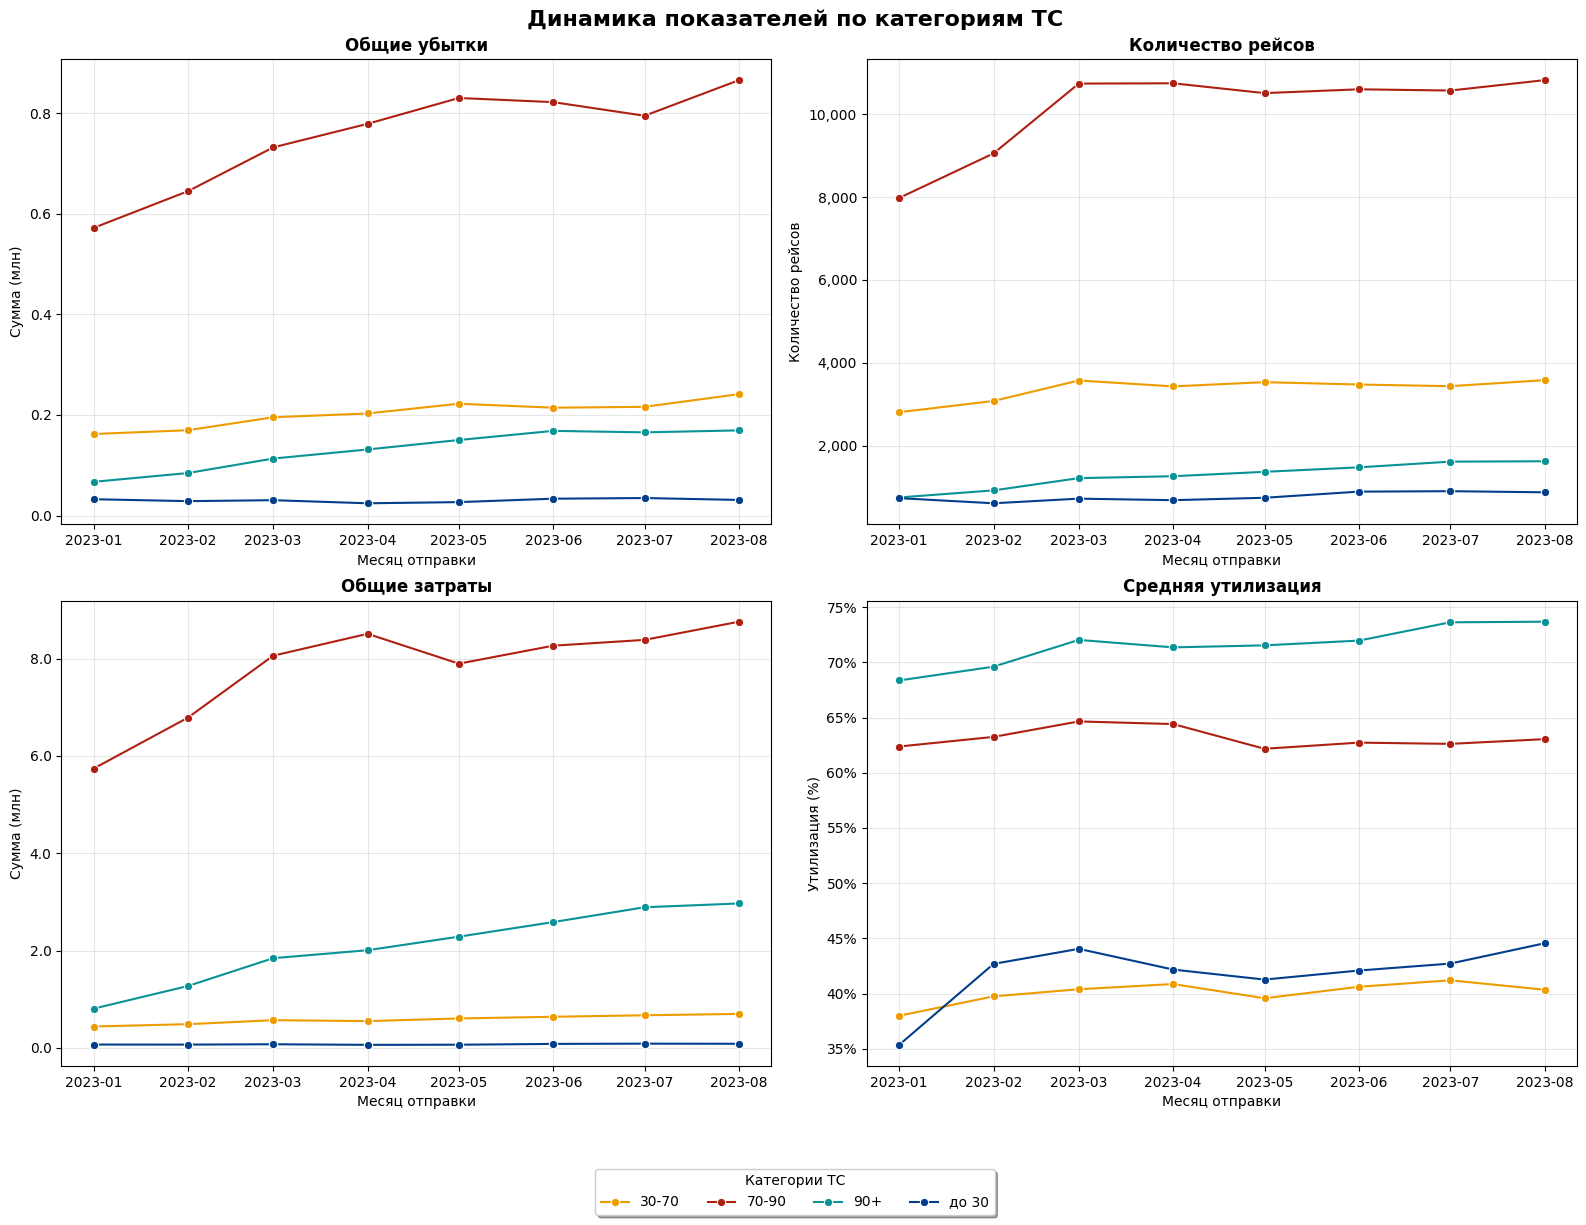

In [96]:
# Создаем сетку графиков 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = {'до 30':'#023e8a','30-70':'#ee9b00','70-90':'#ae2012','90+':'#0a9396'}

# Конфигурация метрик
config = {
    'total_losses': ('Общие убытки', 'money'),
    'trips': ('Количество рейсов', 'count'),
    'total_cost': ('Общие затраты', 'money'),
    'avg_ut': ('Средняя утилизация', 'pct')
}

# Строим графики
for k, (metric, (title, fmt)) in enumerate(config.items()):
    row, col = k // 2, k % 2
    ax = axes[row, col]

    # Лайнплот
    sns.lineplot(data=route_ut_monthly, x='месяц_отправки', y=metric,
                 hue='категория_тс', palette=colors, ax=ax, marker='o')

    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Месяц отправки')
    ax.grid(True, alpha=0.3)

    # Форматирование оси Y
    if fmt == 'pct':
        ax.set_ylabel('Утилизация (%)')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    elif fmt == 'money':
        ax.set_ylabel('Сумма (млн)')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y/1e6:.1f}'))
    else:  # count
        ax.set_ylabel('Количество рейсов')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}'))

# Убираем дублирующиеся легенды и создаем общую
handles, labels = axes[0,0].get_legend_handles_labels()
for ax in axes.flat:
    ax.get_legend().remove()

# Общая легенда
fig.legend(handles, labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.02),
           ncol=4,
           frameon=True,
           fancybox=True,
           shadow=True,
           title='Категории ТС')

plt.suptitle('Динамика показателей по категориям ТС', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Место для легенды
plt.show()



Ключевые моменты :

* Общие убытки от недогруза стабильно растут с начала года для всех категорий кроме до 30.

* Для категории 70-90м3 основными драйверами роста убытков от недогруза являются снижение средней утилизации с апреля и рост общих затрат с мая.

* Для категории 90+ драйвером является довольно существенное увеличение стоимости закупки при медленном росте числа рейсов. При этом, средняя утилизация категории так же растет что говорит о повышении эффективности погрузки таких ТС.

* Для категории 30-70 общий убыток медленно растет вместе с медленным ростом числа рейсов на фоне стабильно низкой утилизации.

**Выводы**

Основной вклад в убытки от недогруза вносит самая массовая категория — фуры 70–90 м3: при средней утилизации всего 63% именно они формируют наибольшие потери.

Среднетоннажные машины 30–70 м3 демонстрируют похожие проблемы с загрузкой, хоть и существенно меньший из-за меньшего количества рейсов.

Крупнотоннажные машины 90+ м3 выделяются лучшей утилизацией (72%) и наиболее низким соотношением убытков к затратам — при высокой стоимости рейсов они используются наиболее эффективно. Для уменьшения убытков от недогруза рекмендуется снижение стоимости закупки ТС этой категории.

В совокупности данные показывают, что повышать экономическую эффективность перевозок нужно прежде всего **за счёт повышения утилизации наиболее массовой категории транспорта — 70–90 м3.**

# 6. Определение самых убыточных направлений

Теперь рассмотрим самые убыточные направления в категориях 70-90м3 и 30-60м3 т.к. эти категории приносят больше всего убытков.

In [97]:
# Фильтруем маршруты категории 30-70 с более чем 10 рейсами
category_filter = (dfu['категория_тс'] == '70-90')
# Группируем по маршрутам
big_routes_groupped = dfu.loc[category_filter].groupby('маршрут').agg(
    trips_amt = ('код_рейса','nunique'),
    utilization = ('утилизация','mean'),
    total_costs = ('фрахт_фактический','sum'),
    total_losses = ('убыток','sum')
).reset_index().sort_values('total_losses',ascending=False)
# считаем среднюю стоимость рейса и средний убыток рейса
big_routes_groupped['avg_cost'] = big_routes_groupped['total_costs'] / big_routes_groupped['trips_amt']
big_routes_groupped['avg_losses'] = big_routes_groupped['total_losses'] / big_routes_groupped['trips_amt']

# Фильтруем маршруты категории 30-70 с более чем 10 рейсами
category_filter = (dfu['категория_тс'] == '30-70')
# Группируем по маршрутам
medium_routes_groupped = dfu.loc[category_filter].groupby('маршрут').agg(
    trips_amt = ('код_рейса','nunique'),
    utilization = ('утилизация','mean'),
    total_costs = ('фрахт_фактический','sum'),
    total_losses = ('убыток','sum')
).reset_index().sort_values('total_losses',ascending=False)
# считаем среднюю стоимость рейса и средний убыток рейса
medium_routes_groupped['avg_cost'] = medium_routes_groupped['total_costs'] / medium_routes_groupped['trips_amt']
medium_routes_groupped['avg_losses'] = medium_routes_groupped['total_losses'] / medium_routes_groupped['trips_amt']



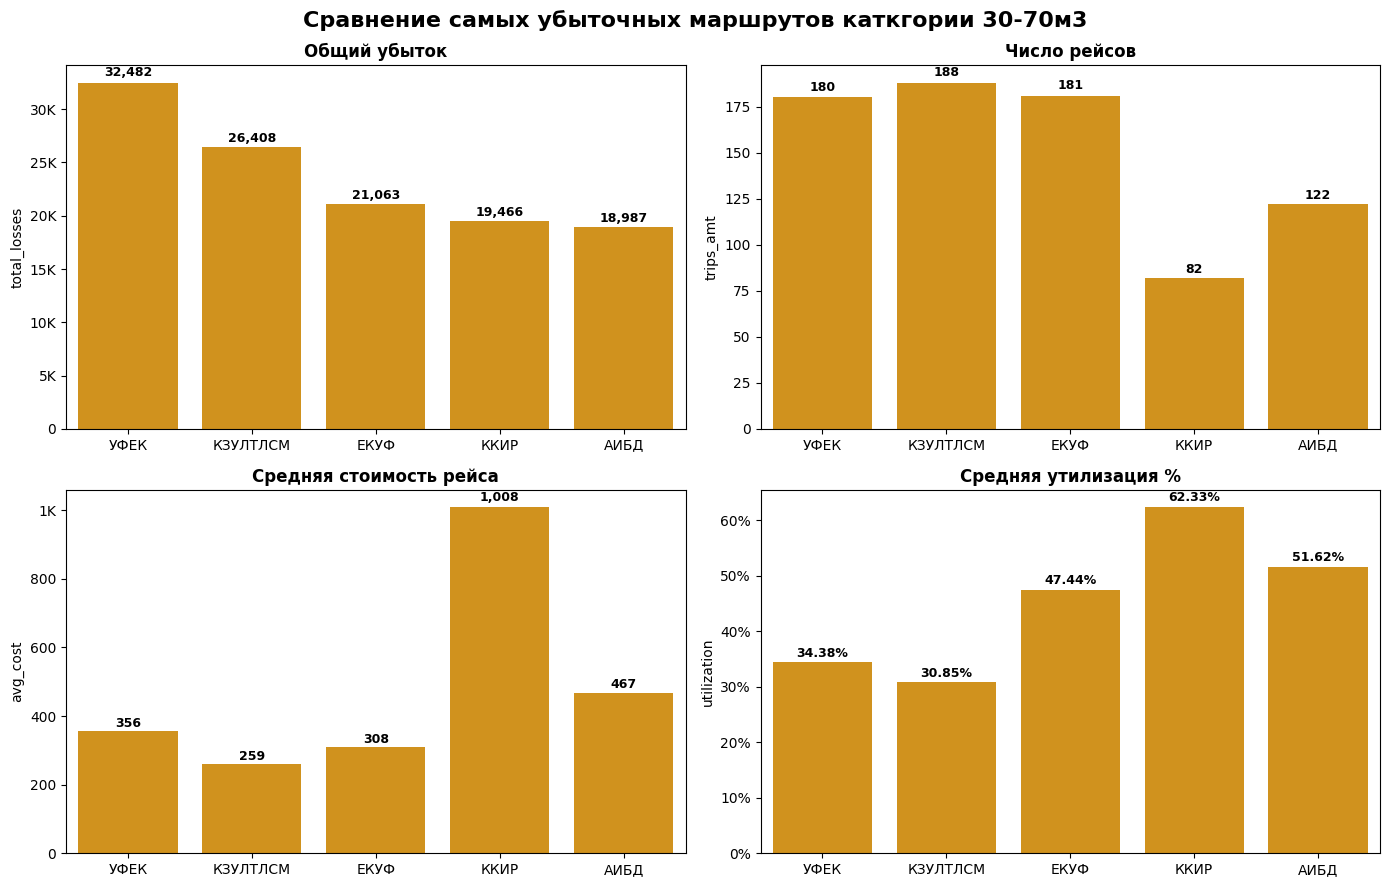

In [98]:
# Создание сетки 2 на 2 для подграфиков
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
# Параметры : Метрика: (название подграфика, формат оси)
config = {
    'total_losses': ('Общий убыток', 'money'),
    'trips_amt': ('Число рейсов', 'count'),
    'avg_cost': ('Средняя стоимость рейса', 'money'),
    'utilization': ('Средняя утилизация %', 'pct')
}
# Данные для графика
plot_data = medium_routes_groupped.head(5)
x_values = 'маршрут'
# Построение графиков
for k, (metric, (title, fmt)) in enumerate(config.items()):
    ax = axes[k//2, k%2]

    # Барплот
    sns.barplot(data=plot_data.sort_values('total_losses',ascending=False), x=x_values, y=metric,
                legend=False, ax=ax,errorbar=('ci', False),color='#ee9b00')
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')

    # Подписи значений на барах
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            text = f'{height:.2f}%' if fmt == 'pct' else f'{height/1e6:.1f}M' if fmt == 'money' and height >= 1e6 else f'{height:,.0f}'
            ax.text(bar.get_x() + bar.get_width()/2, height*1.01, text,
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Форматирование оси У
    if fmt == 'pct':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    elif fmt == 'money':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y/1e6:.1f}M' if y >= 1e6 else f'{y/1e3:.0f}K' if y >= 1e3 else f'{y:,.0f}'))
    else:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}'))
# Оформление
plt.suptitle('Сравнение самых убыточных маршрутов каткгории 30-70м3', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

* Высокие убытки связаны прежде всего с низкой утилизацией (30–35%) маршрутов с большим числом рейсов.

* Можно отметить, что при меньшем кол-ве рейсов у маршрутов ККИР и АИБД более высокая средняя утилизация

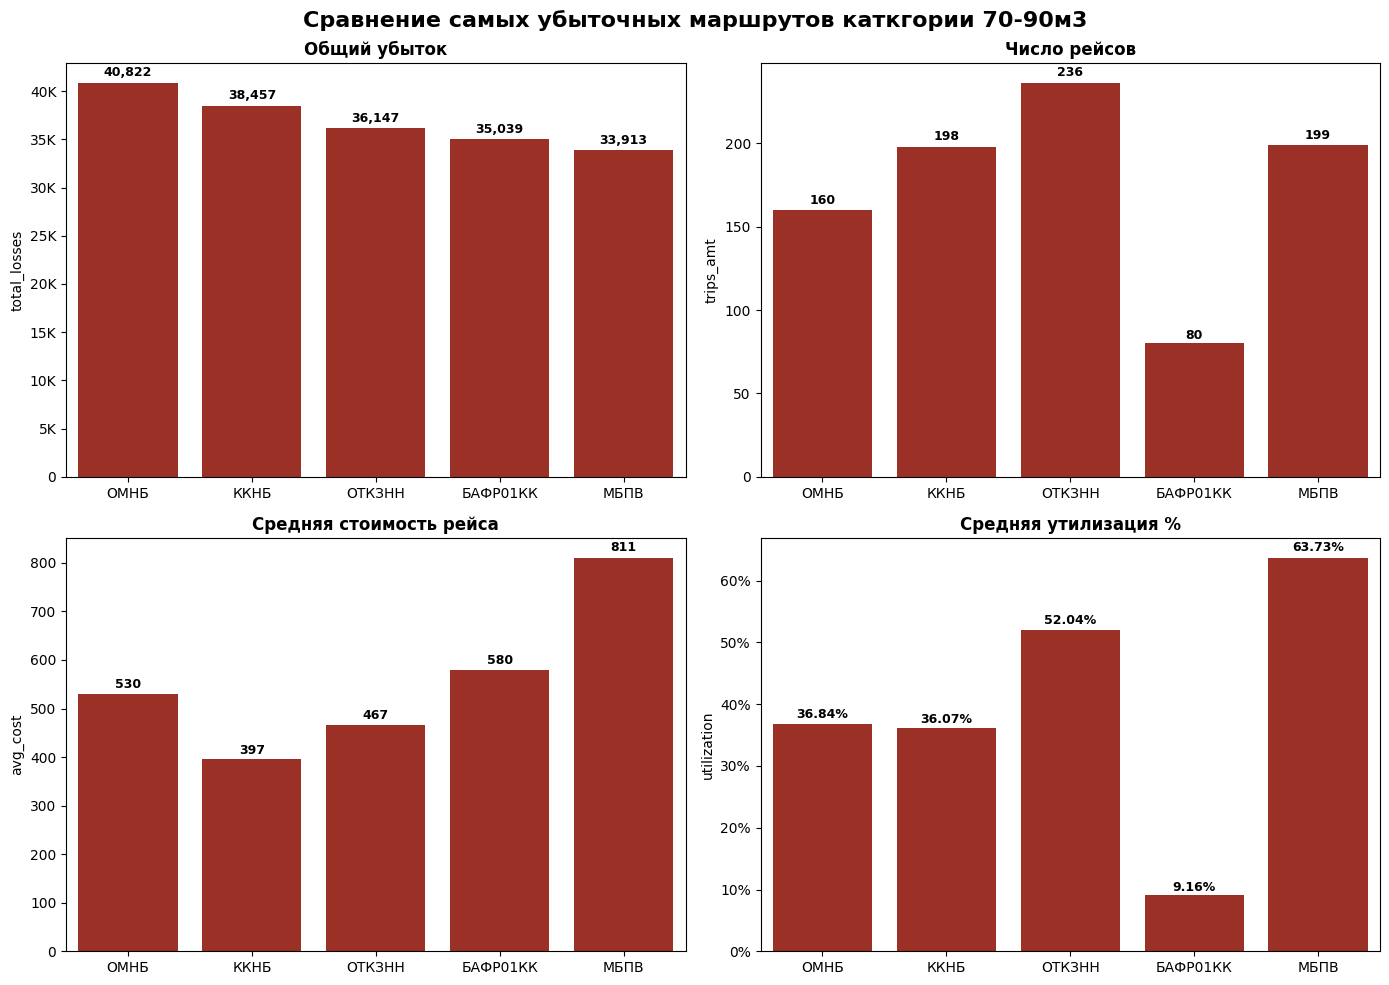

In [99]:
# Создание сетки на 2 для подграфиков
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Параметры : Метрика: (название подграфика, формат оси)
config = {
    'total_losses': ('Общий убыток', 'money'),
    'trips_amt': ('Число рейсов', 'count'),
    'avg_cost': ('Средняя стоимость рейса', 'money'),
    'utilization': ('Средняя утилизация %', 'pct')
}
# Данные для графика
plot_data = big_routes_groupped.head(5)
x_values = 'маршрут'
# Построение графиков
for k, (metric, (title, fmt)) in enumerate(config.items()):
    ax = axes[k//2, k%2]

    # Барплот
    sns.barplot(data=plot_data.sort_values('total_losses',ascending=False), x=x_values, y=metric,
                legend=False, ax=ax,errorbar=('ci', False),color='#ae2012')
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')

    # Подписи значений на барах
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            text = f'{height:.2f}%' if fmt == 'pct' else f'{height/1e6:.1f}M' if fmt == 'money' and height >= 1e6 else f'{height:,.0f}'
            ax.text(bar.get_x() + bar.get_width()/2, height*1.01, text,
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Форматирование оси У
    if fmt == 'pct':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    elif fmt == 'money':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y/1e6:.1f}M' if y >= 1e6 else f'{y/1e3:.0f}K' if y >= 1e3 else f'{y:,.0f}'))
    else:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}'))
# Оформление
plt.suptitle('Сравнение самых убыточных маршрутов каткгории 70-90м3', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Для категории 70-90 ситуация аналогична :

* Самые высокие убытки приносят маршруты с большим числом рейсов и никой утилизацией.

* У маршрута БАФР01КК критически низкая утилизация даже при малом числе рейсов.

* Маршрут МБПВ обладает очень высокой средней стоимостью и большим числом рейсов. Даже при достаточно высокой относительно остальных маршрутов утилизации 63.73% на дистанции он приносит большой убыток.


Теперь рассмотрим динамику убытков по этим маршрутам по месяцам.

In [100]:
group_cols = ['месяц_отправки', 'маршрут']
# Группируем по маршрутам
routes_monthly = dfu.groupby(group_cols).agg(
    trips_amt = ('код_рейса','nunique'),
    utilization = ('утилизация','mean'),
    total_costs = ('фрахт_фактический','sum'),
    total_losses = ('убыток','sum')
).reset_index().sort_values('total_losses',ascending=False)
# считаем среднюю стоимость рейса и средний убыток рейса
routes_monthly['avg_cost'] = routes_monthly['total_costs'] / routes_monthly['trips_amt']
routes_monthly['avg_losses'] = routes_monthly['total_losses'] / routes_monthly['trips_amt']

# Создаем список из 5 худжих по убыткам маршрутов по категории

# 70-90
big_routes = (
    big_routes_groupped.sort_values('total_losses',ascending=False)
    .head(5)
    ['маршрут'].to_list()
)
# 30-70
medium_routes = (
    medium_routes_groupped.sort_values('total_losses',ascending=False)
    .head(5)
    ['маршрут'].to_list()
)

In [101]:
# Функция для построения тепловой карты
def create_combined_heatmap(data, value_col1, value_col2, filter_routes, title):
    """
    Функция строит тепловую карту изменения метрики по месяцам отправки

    ПАРАМЕТРЫ
    data : датасет для построения карты, DataFrame

    value_col1 : основная метрика, str
    value_col2 : дополнительная метрика, str

    filter_routes : маршруты для построения тепловой карты, list

    title : заголовок графика, str
    """
    pivot_data = data.copy(deep=True)
    pivot_data['месяц_отправки'] = pivot_data['месяц_отправки'].dt.to_period('M')

    # Основные данные
    heatmap_data = pivot_data.pivot_table(
        index='маршрут',
        columns='месяц_отправки',
        values=value_col1,
        fill_value=0
    ).loc[filter_routes]

    # Данные для второй метрики
    count_data = pivot_data.pivot_table(
        index='маршрут',
        columns='месяц_отправки',
        values=value_col2,
        fill_value=0
    ).loc[filter_routes]

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(
        heatmap_data,
        annot=False,  # Отключаем стандартные аннотации
        cmap='OrRd',
        linewidths=0.5,
        linecolor='white'
    )

    # Добавляем кастомные аннотации с двумя метриками
    for i in range(len(heatmap_data)):
        for j in range(len(heatmap_data.columns)):
            value1 = heatmap_data.iloc[i, j]
            value2 = count_data.iloc[i, j]
            text = f"{value1:.0f}\n\n({value2:.0f})" if value2 > 0 else f"{value1:.0f}"
            ax.text(j + 0.5, i + 0.5, text,
                   ha='center', va='center', fontsize=9,
                   fontweight='bold' if value2 > 0 else 'normal')

    plt.title(f"{title}\n",
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Месяц')
    plt.ylabel('Маршрут')
    plt.tight_layout()
    plt.show()


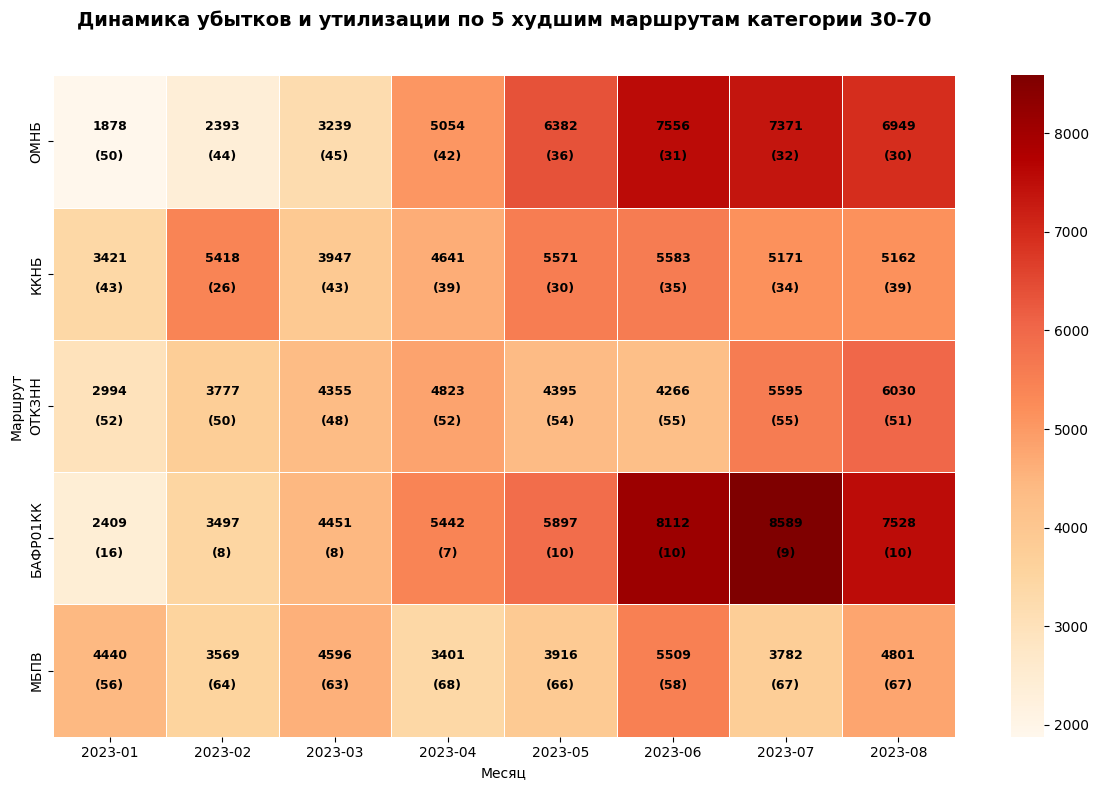

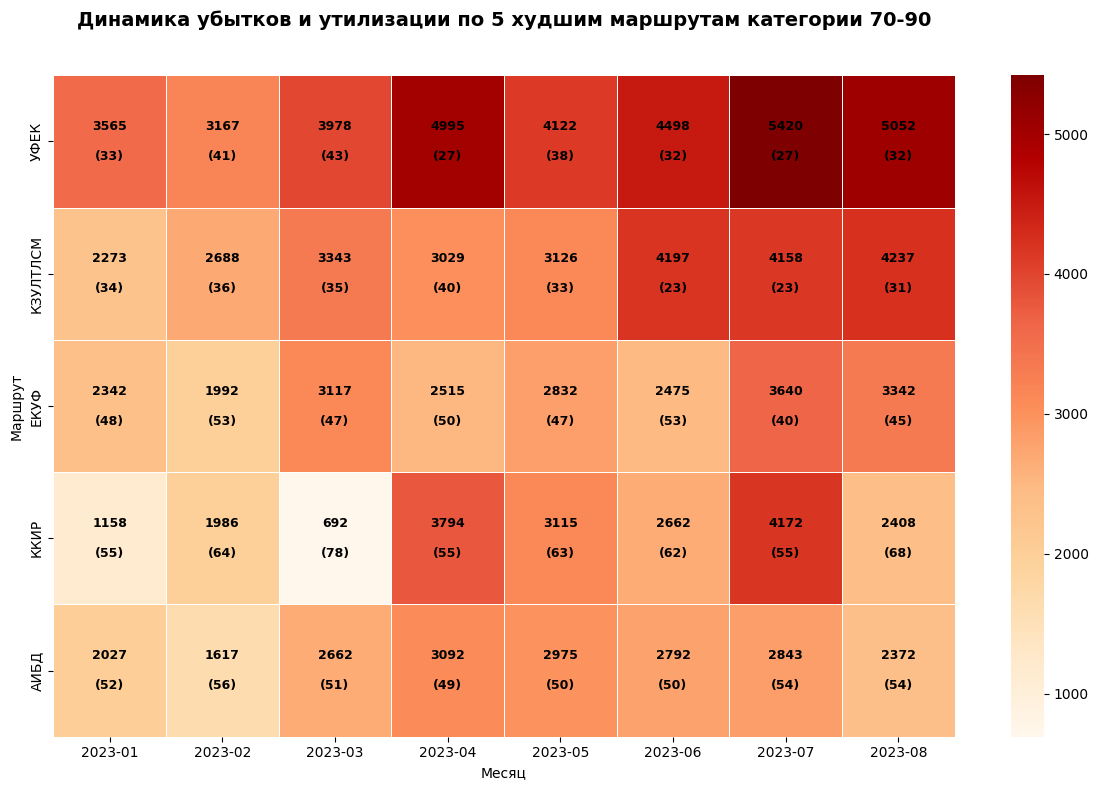

In [102]:
create_combined_heatmap(
    routes_monthly,
    'total_losses','utilization',
    big_routes,
    'Динамика убытков и утилизации по 5 худшим маршрутам категории 30-70'
    )

create_combined_heatmap(
    routes_monthly,
    'total_losses','utilization',
    medium_routes,
    'Динамика убытков и утилизации по 5 худшим маршрутам категории 70-90'
    )

* Для маршрута УФЕК и КЗУЛТЛСМ характерны низкие показатели утилизации и высокие убытки в течение всего года. При этом с июня общие убытки растут.

* Из-за высокой стоимости недогруз на маршруте ККИР приводит к высоким убыткам.

* Следует обратить особое внимание на маршруты ОМНБ и БАФР01КК где с мая наблюдается устойчивый тренд на падение утилизации и рост расходов от недогруза.

**Выводы**

Для маршрутов ОМНБ, УФЕК, КЗУЛТЛСМ и ККНБ основной причиной высоких общих убытков от недогруза является недостаточная утилизация при высоком числе рейсов. Для УФЕК, КЗУЛТЛСМ рекомендуется рассмотреть сокращение рейсов и повышение объема ТС до категории 70-90. Для ОМНБ и ККНБ рекомендуется рассмотреть уменьшение числа рейсов и \ или снижение стоимости на перевозку.

Отдельно стоят маршруты БАФР01КК где в течение всего года утилизация является крайне низкой. Рекомендуется рассмотреть уменьшение категории ТС для перевозок этим маршрутом.

Для маршрутов ККИР и МБПВ рекомендуется уделить особое внимание повышению утилизации - ввиду высокой стоимости рейсов недогруз на этих направлениях приводит к высоким убыткам.

# 7. Анализ показателей тендерных и спотовых рейсов

Для оценки эффективности планирования закупки транспортных средст на самые востребованные направления компании сравним средние показатели тендерных рейсов.

In [103]:
# Определяем тип заказа
dfu['тип_заказа'] = dfu['тендер'].apply(lambda x: 'Тендер' if x != '0' else 'Спот')
#[dfu['категория_тс']=='60-90']
# Группируем
tender_analysis = dfu.groupby('тип_заказа').agg({
    'утилизация': 'mean',
    'убыток': 'sum',
    'фрахт_фактический': 'mean',
    'код_рейса': 'count'
}).round(2)


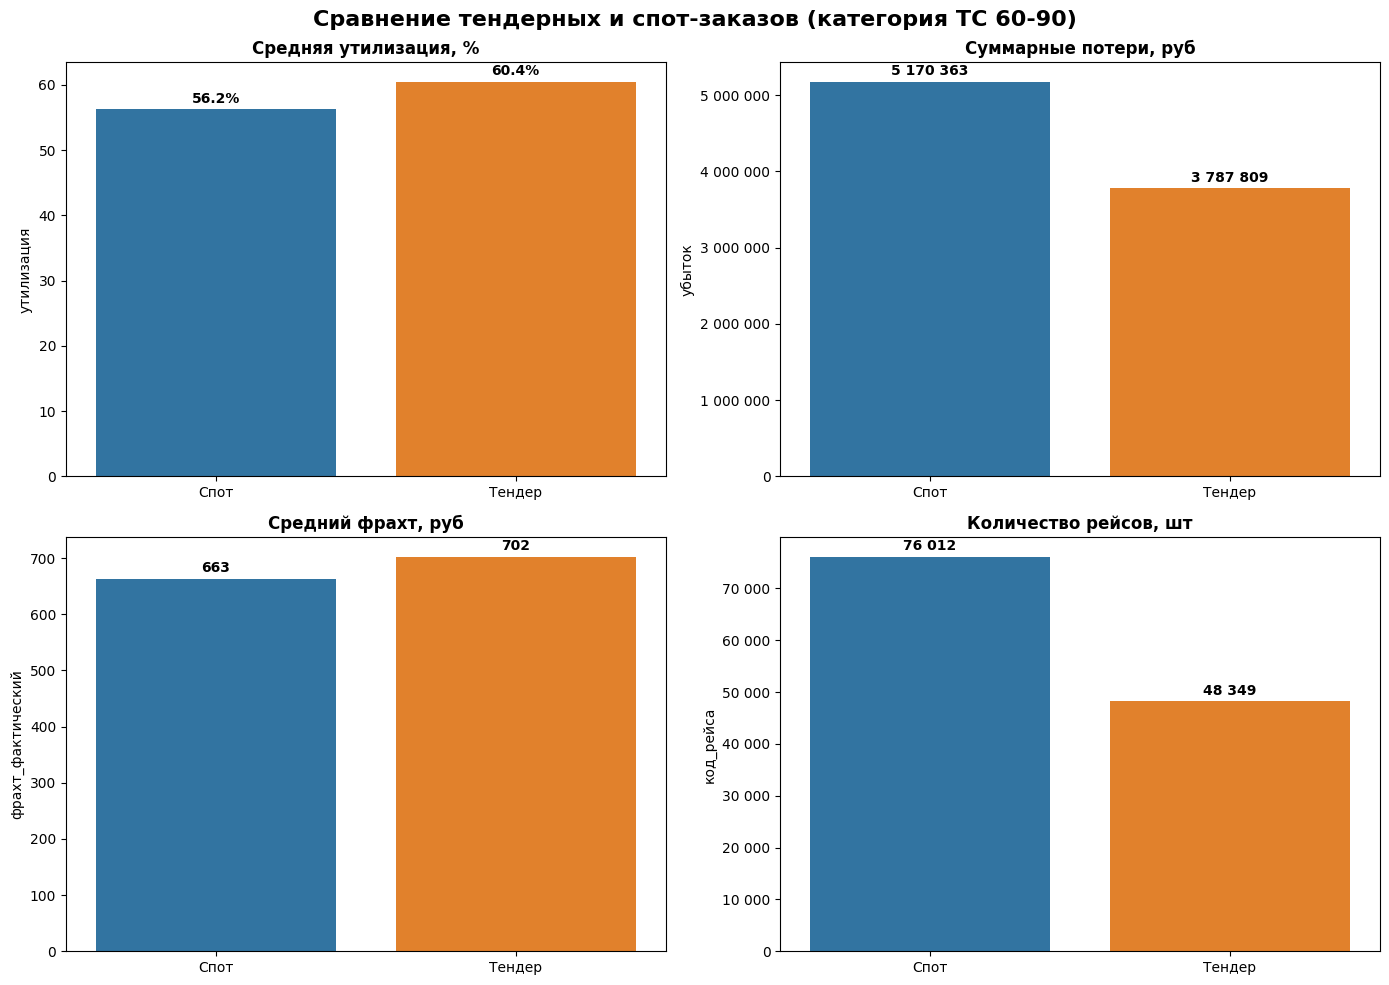

In [104]:
# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['утилизация', 'убыток', 'фрахт_фактический', 'код_рейса']
titles = ['Средняя утилизация, %', 'Суммарные потери, руб', 'Средний фрахт, руб', 'Количество рейсов, шт']

# Создаем DataFrame для визуализации
plot_data = tender_analysis.reset_index()

for k, (metric, title) in enumerate(zip(metrics, titles)):
    row, col = k // 2, k % 2
    ax = axes[row, col]

    # Строим барплот
    sns.barplot(data=plot_data, x='тип_заказа', y=metric, ax=ax,hue='тип_заказа')
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('')

    # Добавляем подписи на бары
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()

            # Форматируем текст в зависимости от метрики
            if metric == 'утилизация':
                text = f'{height:.1f}%'
            else:  # количество рейсов
                text = f'{height:,.0f}'.replace(',', ' ')

            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + (height * 0.01),  # небольшой отступ сверху
                text,
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='bold'
            )

    # Форматируем ось Y
    if metric != 'утилизация':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}'.replace(',', ' ')))

plt.suptitle('Сравнение тендерных и спот-заказов (категория ТС 60-90)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

Несмотря на немного более высокую среднюю стоимость, остальные показатели тендерных рейсов лучше.

Теперь рассмотрим показатели в динамике по месяцам.

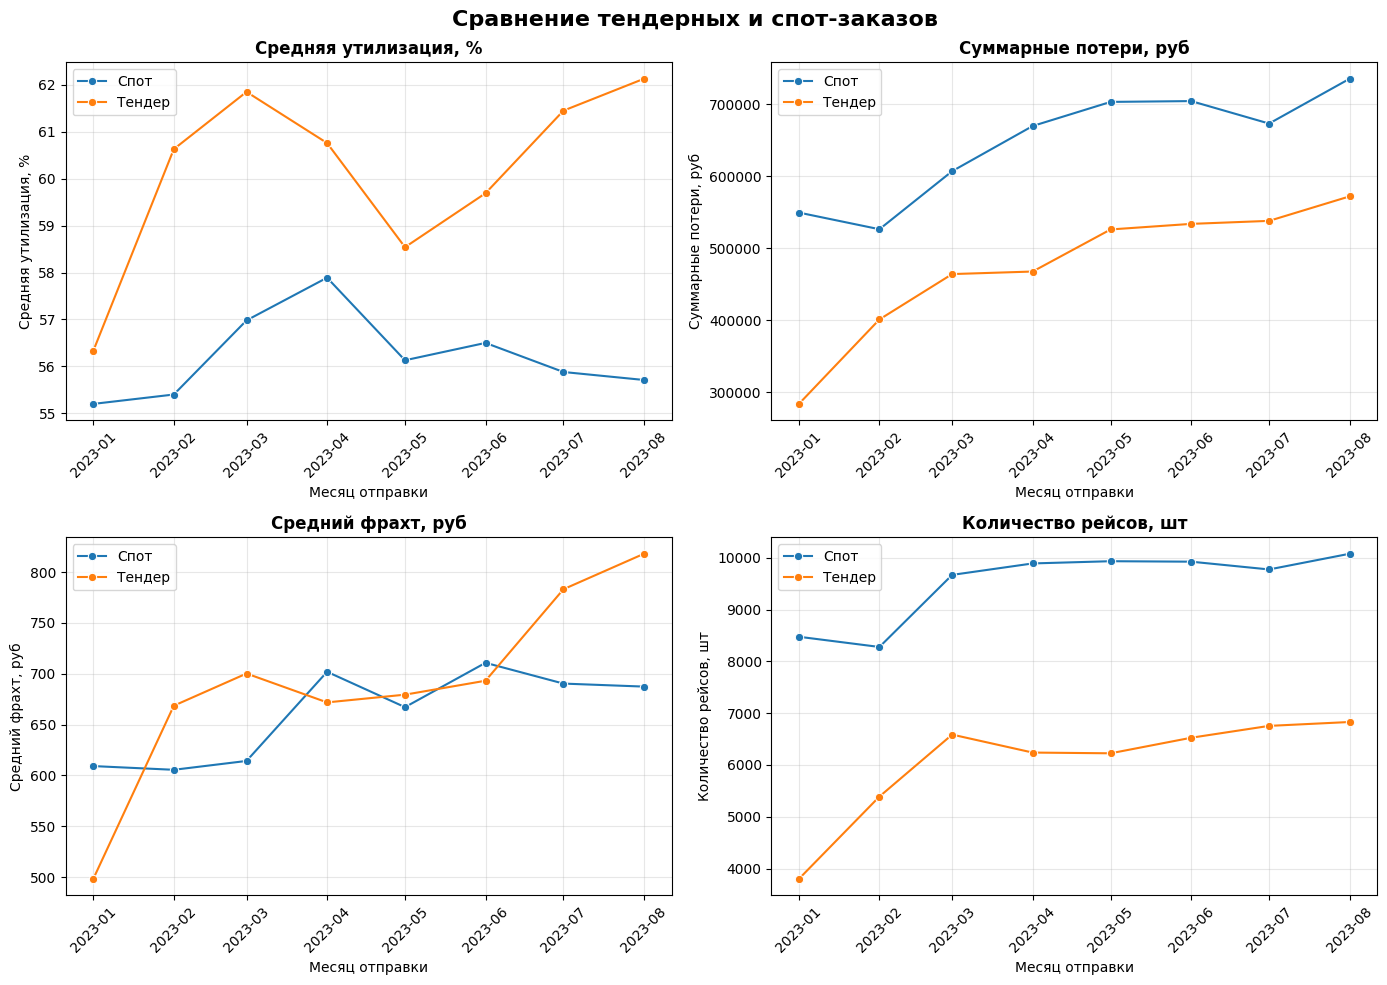

In [105]:
# Агрегируем данные по месяцам
tender_analysis_monthly = dfu.groupby(['тип_заказа','месяц_отправки']).agg({
    'утилизация': 'mean',
    'убыток': 'sum',
    'фрахт_фактический': 'mean',
    'код_рейса': 'count'
}).reset_index().round(2)

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['утилизация', 'убыток', 'фрахт_фактический', 'код_рейса']
titles = ['Средняя утилизация, %', 'Суммарные потери, руб', 'Средний фрахт, руб', 'Количество рейсов, шт']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    row, col = i // 2, i % 2

    # Строим линии для каждого типа заказа
    for order_type in dfu['тип_заказа'].unique():
        data_subset = tender_analysis_monthly[tender_analysis_monthly['тип_заказа'] == order_type]
        sns.lineplot(
            data=data_subset,
            x='месяц_отправки',
            y=metric,
            ax=axes[row, col],
            label=order_type,
            marker='o'
        )

    axes[row, col].set_title(title, fontweight='bold')
    axes[row, col].set_xlabel('Месяц отправки')
    axes[row, col].set_ylabel(title)
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].legend()

plt.suptitle('Сравнение тендерных и спот-заказов', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

Динамика метрик подтверждает общие показатели - тендерные рейсы имеют лучшую утилизацию, при этом убыток от недогруза в них значительно меньше в течение года. Несмотря на резкое снижение утилизации в мае, показатель неукклонно растет.



Основной драйвер роста убытков от недогруза для тендерных рейсов - повышение средней стоимости рейса с июня.

В целом можно сделать выводы о том что стратегия по закрытию самых востребованных направлений с помощью долгосрочных контрактов окупается.

Тем не менее, показатель утилизации все еще далек от целевого.

Определим 5 самых убыточных тендерных направлений.

In [106]:
# Поля для группировки
group_cols = ['маршрут','месяц_отправки']
# Фильтрация для тендерных рейсов
tender_filter =( dfu['тип_заказа'] == 'Тендер')

# Группировка
tender_routes_monthly = dfu.loc[tender_filter].groupby(group_cols).agg(
  trips_amt = ('код_рейса','nunique'),
  utilization = ('утилизация','mean'),
  total_costs = ('фрахт_фактический','sum'),
  total_losses = ('убыток','sum')
).reset_index().sort_values('total_losses',ascending=False)

# Определение самых убыточных маршрутов
tender_routes = (
    dfu[dfu['тип_заказа'] == 'Тендер']
    .groupby(['маршрут'])
    .agg(
        trips_amt=('код_рейса', 'nunique'),
        utilization=('утилизация', 'mean'),
        total_costs=('фрахт_фактический', 'sum'),
        total_losses=('убыток', 'sum')
    )
    .reset_index()
    .query('trips_amt > 10')
    .nlargest(5, 'total_losses')['маршрут']
    .tolist()
)


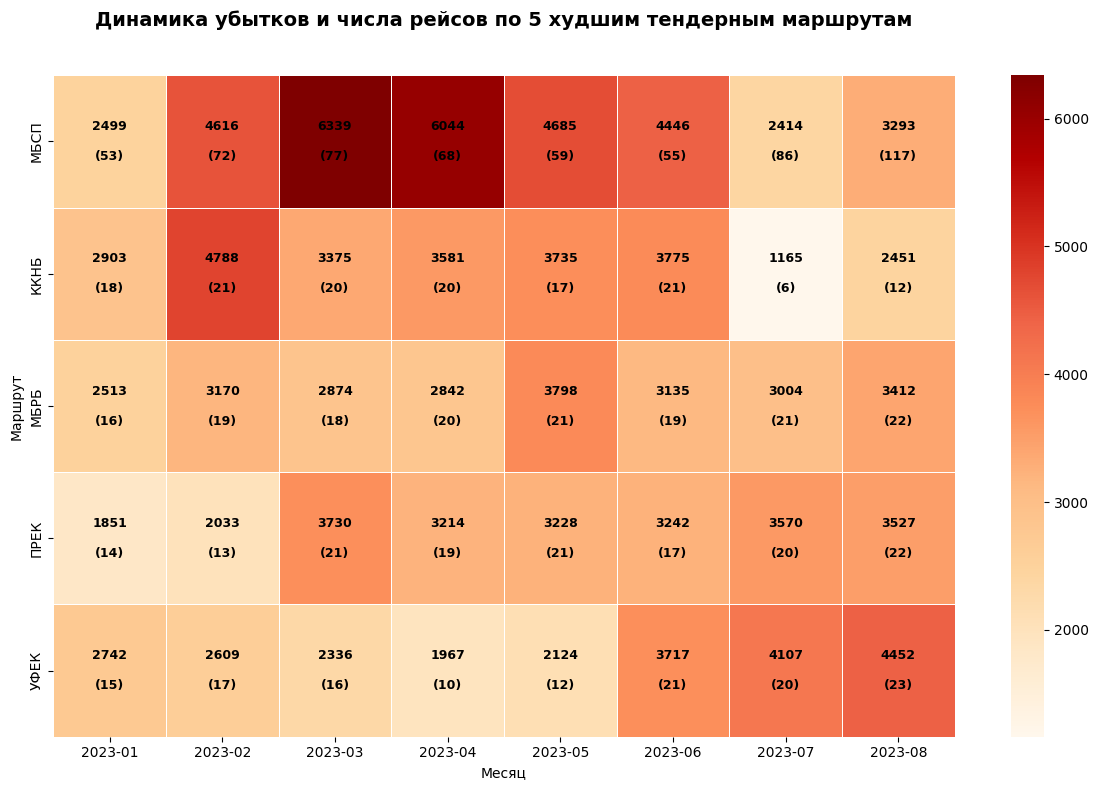

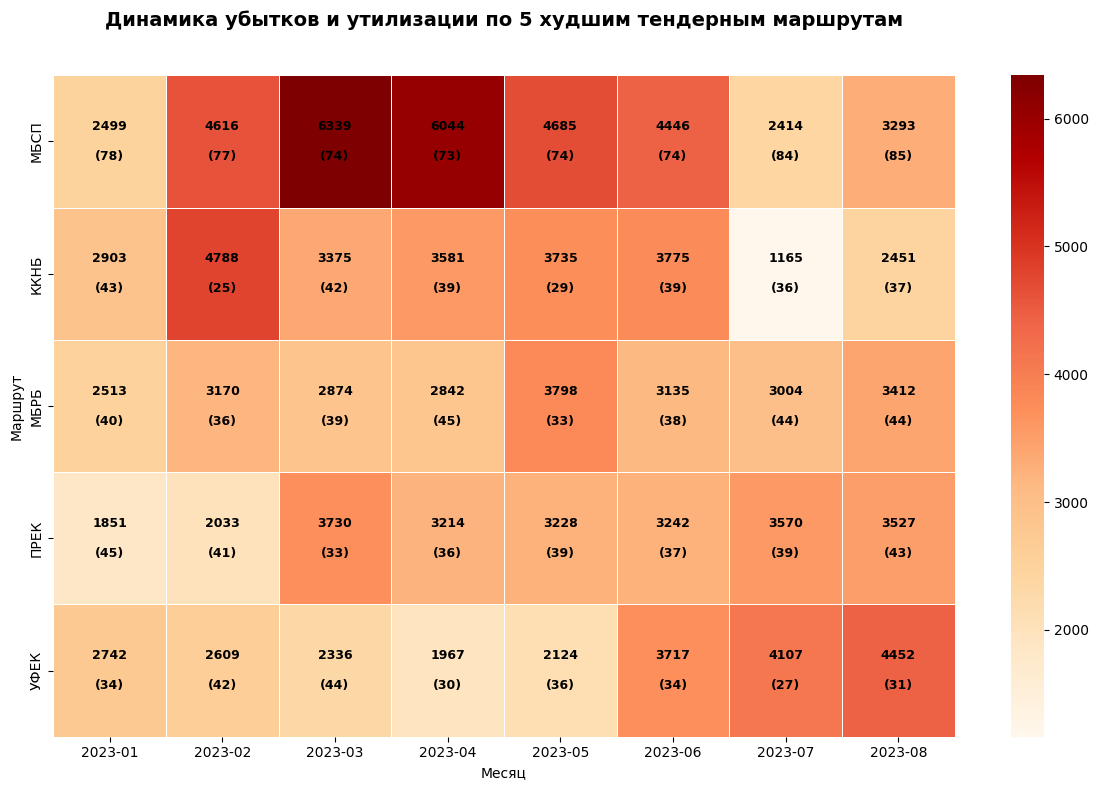

In [107]:
# Тепловая карта
create_combined_heatmap(
    tender_routes_monthly,
    'total_losses','trips_amt',
    tender_routes,
    'Динамика убытков и числа рейсов по 5 худшим тендерным маршрутам'
    )
create_combined_heatmap(
    tender_routes_monthly,
    'total_losses','utilization',
    tender_routes,
    'Динамика убытков и утилизации по 5 худшим тендерным маршрутам'
    )

* Маршрут МБСП показывает максимальные потери в марте и апреле, где число рейсов в месяц от 77 до 68. В мае и июне убытки снижаются вместе с числом рейсов, что показывает оптимизацию закупки транспорта. В июле и августе убытки продолжают падать при росте числа рейсов что гворит о резком увеличении грузопотока.

* Для остальных маршрутов характерна положительная корреляция между числом рейсов и убытками от недогруза - чем меньше рейсов, тем меньше убытки. При этом, несмотря на небольшое кол-во рейсов утилизация в течение всего периода остается крайне низкой. Рекомендуется пересмотреть вывоз из этих направлений - добавить транзитные рейсы через склады, оптимизировать тип ТС и сократить рейсы если это возможно.

# 8. Выводы и рекомендации

1. **Увеличить загрузку категорий 30–70 м³ и до 30 м³**

  Для первой категории можно рассмотреть сокращение рейсов при порвышении объема закупаемых ТС - это позволит сократить расходы и увеличить утилизацию, но может ухудшить сроки доставки.

  Для второй категори рекомендуется рассмотреть сокращение рейсов по маршрутам с минимальной утилизацией, если это невозможно - рассмотреть новые способы организации логистики по этим направлениям (транзитные рейсы, уменьшение объема ТС по направлению при сохранении числа рейсов).


2. **Контроль стоимости закупки для 90+**

  Основным драйвером роста убытков от недогруза по категории служит рост затрат на закупку таких ТС и постепенный рост числа рейсов. При этом, категория в целом показывает минимальное соотношение убытков к затраченным средствам (лучший показатель для всех категорий). Тем не менее, следует с осторожностью масштабировать использование категории т.к. для этой категории крайне важно обеспечить стабильно высокую утилизацию для такой эффективности.
